# Project - LA Traffic

*   IST 652
*   Dr. Block
*   Team: Tyler Marsh, Jon Kaplan, John Fields
*   September 4, 2019




# Introduction

As the second largest city in the United States, Los Angeles has traffic challenges due to a large and growing population and an increase in the number of cars. A better understanding of the factors that contribute to accidents can help government officials, companies, citizens and other interested parties to understand how to make the city safer and more drivable.

The goal is to explore the trends and correlations between the data to provide useful information such as the most dangerous intersections, best/worst times of the day for accidents and other useful information.

# Analysis Questions and Sources


To guide our analysis we came up with a bunch of questions to answer in our analysis:

What are the most dangerous intersections?  

What are the most common collision areas in Los Angeles? 

What are the best/worst times of the day for accidents? Month? 

What is the demographic makeup of victims in collisions? 

Do certain ethnicities, genders, and ages get in more collisions? 

What is the relationship between income and collision victims? 

Do certain temperatures or weather play a factor? 


Sources
https://www.kaggle.com/joemenifee/traffic-collision-eda

Color themes
https://seaborn.pydata.org/tutorial/color_palettes.html

fonts and searborne themes
https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08


Please see the project document in 2U which includes additional information on the introduction, data source, data exploration/cleansing, comparison questions and conclusion.

# Loading and Cleaning the Data

For this code, data is imported with dropbox links of our datasets and files. This made it easier for group members to work together and also doesn't require Colab to be connected to a local machine. Feel free to go to Runtime>Run All

In [1]:
# INSTANT CLEAN 
# run this to get cleaned dataset

import pandas as pd
import numpy as np
import requests
import ast
import plotly
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import datetime
import calendar
import plotly.graph_objs as go
import plotly.offline as offline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
import matplotlib.ticker as ticker
import folium
from folium.plugins import HeatMap


# Theme and styles for visuals
matplotlib.rcParams['font.family'] = "serif" # font
sns.set_context('talk') # visuals outputted for presentation style
plt.style.use('ggplot')


#Read in the csv with the LA traffic data from 2010-2019
la = pd.read_csv("https://www.dropbox.com/s/842vrnr40m7vj5z/traffic-collision-data-from-2010-to-present.csv?dl=1")
#la = pd.read_csv('traffic-collision-data-from-2010-to-present.csv')


# add income and clean
income = pd.read_csv("https://www.dropbox.com/s/okp79hdjkxy5ne3/LAIncomeCouncil.csv?dl=1")
#income = pd.read_csv("/Users/johnfields/Library/Mobile Documents/com~apple~CloudDocs/Syracuse/IST652/MyPythonFiles/Project/los-angeles-traffic-collision-data/LAIncomeCouncil.csv")
#income = pd.read_csv('LAIncomeCouncil.csv')

# Clean income for calculations and make float type
income["Median Income"] = income["Median Income"].str.replace(",","")
income["Median Income"] = income["Median Income"].str.replace(" ","")
income["Median Income"] = income["Median Income"].str.replace('$','')
income['Median Income'].astype(float)

# merge income into LA dataset using the common column of Council Districts
la = la.merge(income, how = 'inner', on = ['Council Districts'])

# drop columns not used in project
la.drop(["DR Number", 
         "Area ID", 
         "Crime Code", 
         "Crime Code Description",
         "Premise Code",
         "Precinct Boundaries",
         "Date Reported", 
         "Neighborhood Councils (Certified)", 
         "Census Tracts", 
         "MO Codes", 
         "LA Specific Plans",
        "Reporting District"],
        axis=1, inplace=True)

# drop NAs in dataset
la.dropna(inplace=True)

# Victim Age needs to be integer
la['Victim Age'] = la['Victim Age'].astype(int)

# Zip Codes needs to be string
la['Zip Codes'] = la['Zip Codes'].astype(int).astype(str)

# Median Income needs to be float
la['Median Income'] = la['Median Income'].astype(float)

# Council District needs to be integer
la['Council Districts'] = la['Council Districts'].astype(int)

# Handling Date
# format date and time
la['Date'] =  pd.to_datetime(la['Date Occurred'],format='%Y/%m/%d')
# break up date to allow more variables for comparison
la['year'] = pd.DatetimeIndex(la['Date']).year # adds years column
la['month'] = pd.DatetimeIndex(la['Date']).month # adds month column
la['weekday']= pd.DatetimeIndex(la['Date']).dayofweek # adds weekday column
la['weekday'] = la['Date'].dt.weekday_name #make it more readable

# break up by year subsets
la_2015 = la[la['year']== 2015]
la_2016 = la[la['year'] == 2016]
la_2017 = la[la['year'] == 2017]
la_2018 = la[la['year'] == 2018]
la_2019 = la[la['year'] == 2019]


#This was moved to below the weather merge due to conflicts
frames = [la_2017, la_2018]
la = pd.concat(frames)

# Handling time, getting hours
la["Time Occurred"] = la["Time Occurred"].astype(str)
la["Time Occurred"] = [i[:2] if len(i) == 4 else i[0] for i in la["Time Occurred"]]
la["Time Occurred"] = la["Time Occurred"].astype(int)
la['hours'] = la['Time Occurred'] # adds hours column

# handling location column, break up into lat and long columns
la['Location'] = [ast.literal_eval(x) for x in la.Location]
la['longitude'] = [x['longitude'] for x in la.Location] # adds longitude column
la['latitude'] = [x['latitude'] for x in la.Location] # adds latitude column
la.longitude = la.longitude.astype(float)
la.latitude = la.latitude.astype(float)

# drop more columns not needed
la = la.drop(['Date Occurred'],axis=1)



# show final rows and columns for dataset, should now be 90845 rows and 19 columns
dataframe_rows, dataframe_cols = la.shape
print("The dimensions of the cleaned Los Angeles Collision dataset is",dataframe_rows,"rows and",dataframe_cols,"columns.")

The dimensions of the cleaned Los Angeles Collision dataset is 90845 rows and 19 columns.


In [0]:
# Theme and styles for visuals
matplotlib.rcParams['font.family'] = "serif" # font
sns.set_context('talk') # visuals outputted for presentation style
plt.style.use('ggplot')

In [3]:
# confirm years of data are in scope of 2017 and 2018
la.year.unique()

array([2017, 2018])

In [4]:
# confirm data types are changed to desired type
la.dtypes

Time Occurred                   int64
Area Name                      object
Victim Age                      int64
Victim Sex                     object
Victim Descent                 object
Premise Description            object
Address                        object
Cross Street                   object
Location                       object
Zip Codes                      object
Council Districts               int64
Median Income                 float64
Date                   datetime64[ns]
year                            int64
month                           int64
weekday                        object
hours                           int64
longitude                     float64
latitude                      float64
dtype: object

In [5]:
# confirm there are no NULL values in cleaned dataset
pd.isnull(la).sum()

Time Occurred          0
Area Name              0
Victim Age             0
Victim Sex             0
Victim Descent         0
Premise Description    0
Address                0
Cross Street           0
Location               0
Zip Codes              0
Council Districts      0
Median Income          0
Date                   0
year                   0
month                  0
weekday                0
hours                  0
longitude              0
latitude               0
dtype: int64

# Data Summary

In [6]:
la.head() #show final dataset rows

,Time Occurred,Area Name,Victim Age,Victim Sex,Victim Descent,Premise Description,Address,Cross Street,Location,Zip Codes,Council Districts,Median Income,Date,year,month,weekday,hours,longitude,latitude
4920,13,Devonshire,74,F,A,STREET,NORDHOFF ST,LOUISE AV,"{'longitude': '-118.5113', 'human_address': '{...",18514,2,61000.0,2017-12-31,2017,12,Sunday,13,-118.5113,34.2359
4921,21,Devonshire,21,M,B,STREET,BALBOA BL,CHATSWORTH ST,"{'longitude': '-118.5023', 'human_address': '{...",19329,2,61000.0,2017-12-31,2017,12,Sunday,21,-118.5023,34.2648
4922,23,Devonshire,31,M,O,STREET,ZELZAH AV,TRIBUNE ST,"{'longitude': '-118.5234', 'human_address': '{...",19329,2,61000.0,2017-12-31,2017,12,Sunday,23,-118.5234,34.2686
4923,6,West Valley,54,M,O,STREET,SATICOY ST,RESEDA BL,"{'longitude': '-118.536', 'human_address': '{""...",18909,2,61000.0,2017-12-31,2017,12,Sunday,6,-118.5360,34.2084
4924,12,Topanga,28,M,W,STREET,PLATT AV,VICTORY BL,"{'longitude': '-118.6426', 'human_address': '{...",4283,2,61000.0,2017-12-30,2017,12,Saturday,12,-118.6426,34.1898


In [7]:
summary = la.describe()
summary = summary.transpose()
print(summary)

                     count          mean  ...         75%         max
Time Occurred      90845.0     13.536133  ...     18.0000     23.0000
Victim Age         90845.0     41.809720  ...     52.0000     99.0000
Council Districts  90845.0      8.344202  ...     12.0000     15.0000
Median Income      90845.0  56101.622544  ...  75100.0000  90100.0000
year               90845.0   2017.502515  ...   2018.0000   2018.0000
month              90845.0      6.560262  ...     10.0000     12.0000
hours              90845.0     13.536133  ...     18.0000     23.0000
longitude          90845.0   -118.363911  ...   -118.2824   -118.1554
latitude           90845.0     34.083449  ...     34.1794     34.3328

[9 rows x 8 columns]


# Loading Additional Weather Data

In [0]:
#Read in the csv with the LA weather data from 2017-2018
weather2017 = pd.read_csv('https://www.dropbox.com/s/46900zctddjvpwl/2017weather.csv?dl=1')
#weather2017 = pd.read_csv('/Users/johnfields/Library/Mobile Documents/com~apple~CloudDocs/Syracuse/IST652/Project/LA weather data/2017weather.csv')
#weather2017 = pd.read_csv('/Users/Jon/2017weather.csv')
weather2018 = pd.read_csv('https://www.dropbox.com/s/0fokdyib2fvxo9g/2018weather_clean2.csv?dl=1')
#weather2018 = pd.read_csv('/Users/johnfields/Library/Mobile Documents/com~apple~CloudDocs/Syracuse/IST652/Project/LA weather data/2018weather_clean2.csv')
#weather2018 = pd.read_csv('/Users/Jon/2018weather_clean2.csv')
weather = pd.concat([weather2017, weather2018])
weather['Date'] =  pd.to_datetime(weather['Date'])


In [9]:
weather.head()

,Unnamed: 0,Date,HighTemp,LowTemp,AverageTemp,Precipitation,NauticalTwilightRise,NauticalTwilightSet
0,0,2017-01-01,55,39,47,0.00,6:01,5:54
1,1,2017-01-02,54,48,51,0.00,6:01,5:55
2,2,2017-01-03,55,45,50,0.00,6:01,5:56
3,3,2017-01-04,57,46,52,0.07,6:02,5:57
4,4,2017-01-05,61,52,56,0.31,6:02,5:57


In [10]:
weather.columns # need to get rid of Unnamed column

Index(['Unnamed: 0', 'Date', 'HighTemp', 'LowTemp', 'AverageTemp',
       'Precipitation', 'NauticalTwilightRise', 'NauticalTwilightSet'],
      dtype='object')

In [11]:
#Merge the la and weather dataframes on date
laWeather = la.merge(weather, how = 'inner', on = ['Date'])

# make new column for rain or not; this will allow us to do comparisons between days with rain and without
laWeather['rain'] = np.where(laWeather['Precipitation']>0, 'yes', 'no')

laWeather.drop(["Unnamed: 0", "Location"], axis= 1, inplace=True) #drop not needed columns


# show final rows and columns for dataset, should be 89381 rows and 25 columns
dataframe_rows, dataframe_cols = laWeather.shape
print("The dimensions of the cleaned Los Angeles Collision Weather dataset is",dataframe_rows,"rows and",dataframe_cols,"columns.")

The dimensions of the cleaned Los Angeles Collision Weather dataset is 89381 rows and 25 columns.


In [12]:
laWeather.head()

,Time Occurred,Area Name,Victim Age,Victim Sex,Victim Descent,Premise Description,Address,Cross Street,Zip Codes,Council Districts,Median Income,Date,year,month,weekday,hours,longitude,latitude,HighTemp,LowTemp,AverageTemp,Precipitation,NauticalTwilightRise,NauticalTwilightSet,rain
0,13,Devonshire,74,F,A,STREET,NORDHOFF ST,LOUISE AV,18514,2,61000.0,2017-12-31,2017,12,Sunday,13,-118.5113,34.2359,70,48,59,0.0,6:01,5:54,no
1,21,Devonshire,21,M,B,STREET,BALBOA BL,CHATSWORTH ST,19329,2,61000.0,2017-12-31,2017,12,Sunday,21,-118.5023,34.2648,70,48,59,0.0,6:01,5:54,no
2,23,Devonshire,31,M,O,STREET,ZELZAH AV,TRIBUNE ST,19329,2,61000.0,2017-12-31,2017,12,Sunday,23,-118.5234,34.2686,70,48,59,0.0,6:01,5:54,no
3,6,West Valley,54,M,O,STREET,SATICOY ST,RESEDA BL,18909,2,61000.0,2017-12-31,2017,12,Sunday,6,-118.5360,34.2084,70,48,59,0.0,6:01,5:54,no
4,8,Hollywood,46,F,W,STREET,SUNSET BL,HIGHLAND AV,23446,8,34300.0,2017-12-31,2017,12,Sunday,8,-118.3405,34.0980,70,48,59,0.0,6:01,5:54,no


In [13]:
laWeather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89381 entries, 0 to 89380
Data columns (total 25 columns):
Time Occurred           89381 non-null int64
Area Name               89381 non-null object
Victim Age              89381 non-null int64
Victim Sex              89381 non-null object
Victim Descent          89381 non-null object
Premise Description     89381 non-null object
Address                 89381 non-null object
Cross Street            89381 non-null object
Zip Codes               89381 non-null object
Council Districts       89381 non-null int64
Median Income           89381 non-null float64
Date                    89381 non-null datetime64[ns]
year                    89381 non-null int64
month                   89381 non-null int64
weekday                 89381 non-null object
hours                   89381 non-null int64
longitude               89381 non-null float64
latitude                89381 non-null float64
HighTemp                89381 non-null int64
LowTemp      

In [14]:
# confirm there are no NULL values in cleaned weather dataset
pd.isnull(laWeather).sum()

Time Occurred           0
Area Name               0
Victim Age              0
Victim Sex              0
Victim Descent          0
Premise Description     0
Address                 0
Cross Street            0
Zip Codes               0
Council Districts       0
Median Income           0
Date                    0
year                    0
month                   0
weekday                 0
hours                   0
longitude               0
latitude                0
HighTemp                0
LowTemp                 0
AverageTemp             0
Precipitation           0
NauticalTwilightRise    0
NauticalTwilightSet     0
rain                    0
dtype: int64

# Analysis: Weather

In [15]:
# a weather correlation matrix was created to see what kind of relationships each variable had with one another

corr = laWeather.corr()
corr.style.background_gradient(cmap='coolwarm')

,Time Occurred,Victim Age,Council Districts,Median Income,year,month,hours,longitude,latitude,HighTemp,LowTemp,AverageTemp,Precipitation
Time Occurred,1,-0.0347614,-0.00741177,0.0027954,-0.00642427,0.00304863,1,-0.0132638,0.00538926,0.0101182,0.00474773,0.00851484,-0.00413827
Victim Age,-0.0347614,1,-0.0242683,0.0149118,0.00802359,-0.000950346,-0.0347614,-0.0422101,0.0150934,-0.00861897,-0.0104995,-0.0100573,0.00531789
Council Districts,-0.00741177,-0.0242683,1,-0.238213,-0.0137835,-0.00153818,-0.00741177,0.69603,-0.899175,0.00363071,0.00294944,0.00354173,-0.00931424
Median Income,0.0027954,0.0149118,-0.238213,1,0.00878519,-0.000351768,0.0027954,-0.320197,0.358039,0.000770152,0.00162546,0.0011945,0.0082578
year,-0.00642427,0.00802359,-0.0137835,0.00878519,1,-0.0038598,-0.00642427,-0.0127322,0.0128872,-0.0702202,-0.0443034,-0.0623582,0.0301172
month,0.00304863,-0.000950346,-0.00153818,-0.000351768,-0.0038598,1,0.00304863,-0.00305134,0.00121499,0.309216,0.244934,0.301942,-0.132701
hours,1,-0.0347614,-0.00741177,0.0027954,-0.00642427,0.00304863,1,-0.0132638,0.00538926,0.0101182,0.00474773,0.00851484,-0.00413827
longitude,-0.0132638,-0.0422101,0.69603,-0.320197,-0.0127322,-0.00305134,-0.0132638,1,-0.616481,-0.000835484,0.000315085,-0.000357438,-0.0017576
latitude,0.00538926,0.0150934,-0.899175,0.358039,0.0128872,0.00121499,0.00538926,-0.616481,1,-0.00513514,-0.0029036,-0.00445598,0.0123236
HighTemp,0.0101182,-0.00861897,0.00363071,0.000770152,-0.0702202,0.309216,0.0101182,-0.000835484,-0.00513514,1,0.752336,0.951599,-0.294088


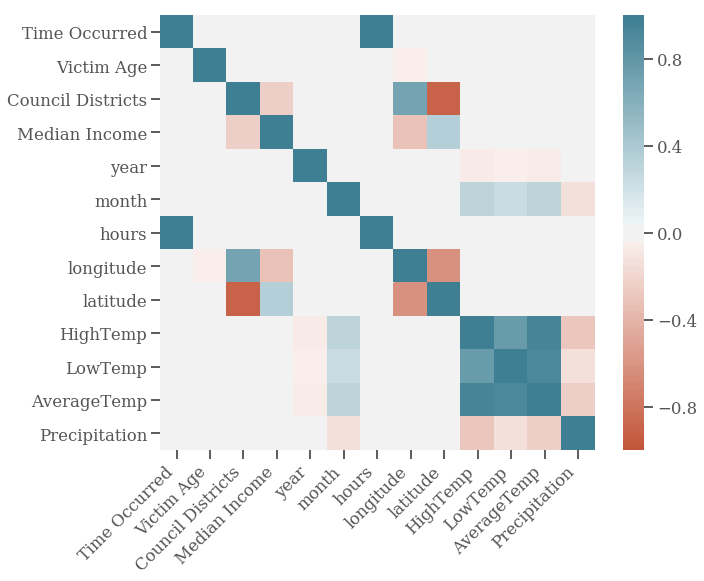

In [16]:
# weather correlation matrix 2
fig,ax = plt.subplots(figsize=(10,8))
corr = laWeather.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

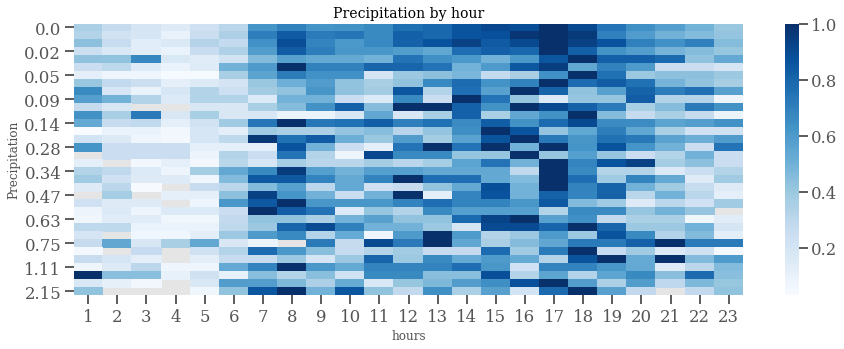

In [17]:
# precipitation by hour heatmap
#x = ['1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm', '12am']
rain_hour_pt = laWeather.pivot_table(index='Precipitation', columns='hours', aggfunc='size')
rain_hour_pt = rain_hour_pt.apply(lambda x: x / rain_hour_pt.max(axis=1))
plt.figure(figsize=(15,5))
plt.title('Precipitation by hour', fontsize=14)
#plt.xlabel('x')
sns.heatmap(rain_hour_pt, cbar=True, annot=False, fmt=".0f", cmap="Blues");

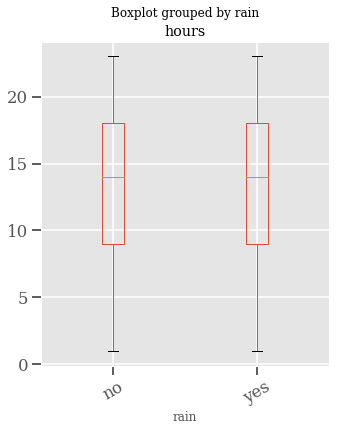

In [18]:
# boxplot showing hours of day collisions with rain or not, time of day most collisions occurs seems to be same, near 3pm average regardless
laWeather.boxplot('hours', 'rain', rot = 30,figsize=(5,6))

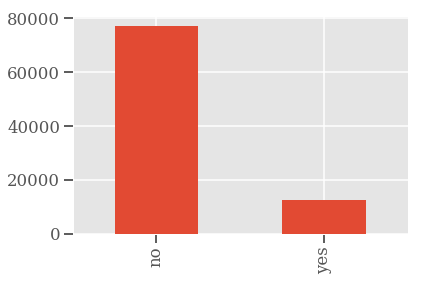

In [19]:
# rainy days vs dry days


laWeather['rain'].value_counts().plot(kind='bar')

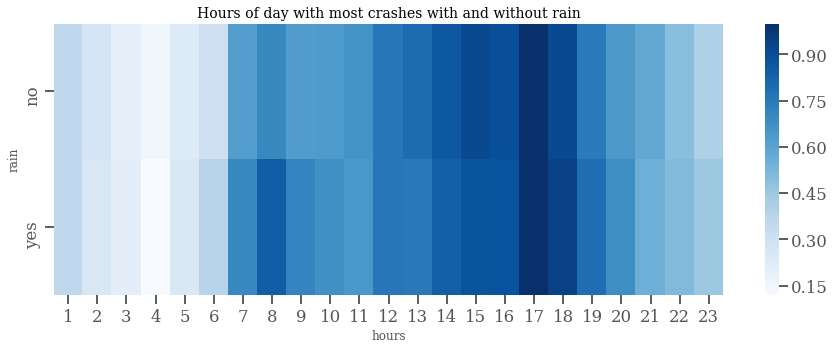

In [20]:
# hours of day with most crashes with and without rain
rain_hour_pt = laWeather.pivot_table(index='rain', columns='hours', aggfunc='size')
rain_hour_pt = rain_hour_pt.apply(lambda x: x / rain_hour_pt.max(axis=1))
plt.figure(figsize=(15,5))
plt.title('Hours of day with most crashes with and without rain', fontsize=14)
sns.heatmap(rain_hour_pt, cbar=True, annot=False, fmt=".0f", cmap="Blues");

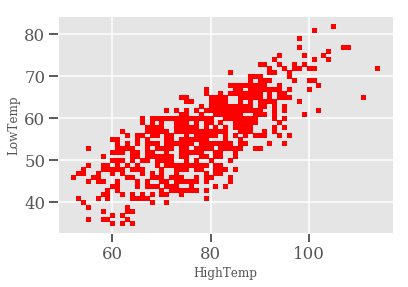

In [21]:
# Create plot of Latitude and Longitude of Accidents by Temperature
# Import matpolotlib for visualizations
#import matplotlib.pyplot as plt

plt.close('all')
laWeather.plot(kind='scatter',x='HighTemp',y='LowTemp',color='red')
plt.show()

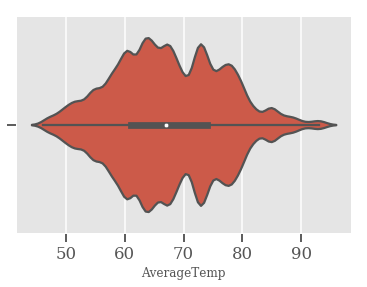

In [22]:
# average temp distribution

sns.violinplot(x='AverageTemp', data=laWeather)


In [23]:
# average temp
laWeather['AverageTemp'].mean()

67.46490864948926

In [24]:
# rainy day analysis

rainydays = laWeather[laWeather['rain']== "yes"]
rainydays.head()



,Time Occurred,Area Name,Victim Age,Victim Sex,Victim Descent,Premise Description,Address,Cross Street,Zip Codes,Council Districts,Median Income,Date,year,month,weekday,hours,longitude,latitude,HighTemp,LowTemp,AverageTemp,Precipitation,NauticalTwilightRise,NauticalTwilightSet,rain
1217,19,Devonshire,77,M,A,STREET,DEVONSHIRE ST,E HASKELL AV,19329,2,61000.0,2017-12-20,2017,12,Wednesday,19,-118.4761,34.2574,59,42,51,1.000000e-16,5:57,5:47,yes
1218,9,Devonshire,63,M,W,STREET,CHATSWORTH ST,TOPANGA CANYON BL,4284,2,61000.0,2017-12-20,2017,12,Wednesday,9,-118.6061,34.2645,59,42,51,1.000000e-16,5:57,5:47,yes
1219,13,Devonshire,47,F,H,STREET,RESEDA BL,SAN FERNANDO MISSION BL,18905,2,61000.0,2017-12-20,2017,12,Wednesday,13,-118.5361,34.2718,59,42,51,1.000000e-16,5:57,5:47,yes
1220,11,Devonshire,23,F,W,STREET,GOTHIC AV,DEVONSHIRE ST,19329,2,61000.0,2017-12-20,2017,12,Wednesday,11,-118.4892,34.2575,59,42,51,1.000000e-16,5:57,5:47,yes
1221,1,Devonshire,31,M,W,STREET,PARTHENIA ST,CORBIN AV,18513,2,61000.0,2017-12-20,2017,12,Wednesday,1,-118.5623,34.2282,59,42,51,1.000000e-16,5:57,5:47,yes


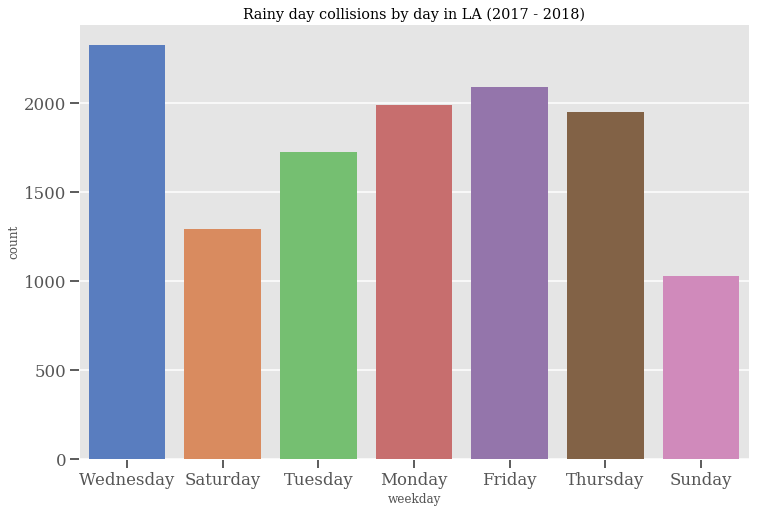

In [25]:
# collisions by rainy weekday
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'weekday',data = rainydays,palette='muted')
#ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], fontsize=10)
ax.set_title('Rainy day collisions by day in LA (2017 - 2018)');

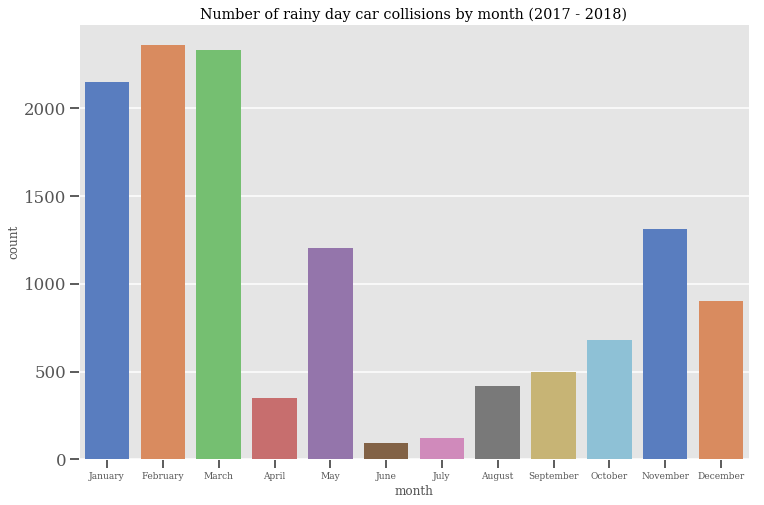

In [26]:
# collisions by rainy months
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = rainydays,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of rainy day car collisions by month (2017 - 2018)');

In [27]:
rainydays['AverageTemp'].mean()

59.94631629856521

# Analysis: Location (MapBox)

Some of the visualizations in the analysis section use MapBox which requires an API token to run.  These tokens are included but please do not share the code publicly with the keys.  Also, some MapBox visualizations are created in a separate browser window.

In [28]:
## Visualize the data with MapBox
# Source of Map Code: https://towardsdatascience.com/famished-on-the-freeway-visualizing-mapping-la-restaurant-inspections-cb6bc8338111

# in case html doesn't output locally, check out the html file sample in the included zip

mapbox_token="pk.eyJ1IjoianRmaWVsZHMiLCJhIjoiY2p5dWxxcXJxMDF3ZjNtcm9iYmkyZ2w2ZSJ9.353KtPjbC39lk9uVt3r8PQ"
#data parameters from the file to map
trace = go.Scattermapbox(lat = laWeather["latitude"], lon = laWeather["longitude"], marker=go.Marker(size=10), mode="markers+text")
data = [trace]
#define map layout - access token (API), which location map should be centered on
layout = go.Layout(mapbox=dict(accesstoken=mapbox_token,center=dict(lat=33.9703, lon=-118.2775), zoom=10))
#finalize data and layout
figure = go.Figure(data = data, layout = layout)
#draw the map NOTE: map will open in your default browser - new tab
offline.plot(figure)

#33.9703° N, 118.2775° W - 77th st POLICE STATION

/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:426: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




'file:///content/temp-plot.html'

In [29]:
##Create a different MapBox view of the same data
shaz13_custom_style = "mapbox://styles/shaz13/cjiog1iqa1vkd2soeu5eocy4i"
#set the geo=spatial data
data = [go.Scattermapbox(lat = laWeather["latitude"], lon = laWeather["longitude"],mode='markers',
    marker=dict(size= 4,color = 'gold',opacity = .8,),)]
#set the layout to plot
layout = go.Layout(autosize=False,mapbox= dict(accesstoken=mapbox_token,
    bearing=10,pitch=60,zoom=13,center= dict(lat=34.03,lon=-118.46),
    style=shaz13_custom_style),width=900,height=600,title = "LA Traffic Collisions 2017-2018")
fig = dict(data=data, layout=layout)
offline.plot(fig)

'file:///content/temp-plot.html'

In [30]:
##Create a Map Box plot which also includes weather data
#Hot Days
hot = laWeather[laWeather['HighTemp'] > 100]
#Cool Days
cool = laWeather[laWeather['LowTemp'] < 40]
data = [go.Scattermapbox(
            lat= hot['latitude'] ,
            lon= hot['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'gold',
                opacity = .8),
            name ='Hot'
          ),
        go.Scattermapbox(
            lat= cool['latitude'] ,
            lon= cool['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'cyan',
                opacity = .8),
            name ='Cool'
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken=mapbox_token,
                                bearing=10,
                                pitch=60,
                                zoom=11,
                                center= dict(
                                         lat=34.0482,
                                         lon=-118.4),
                                style= "mapbox://styles/shaz13/cjiog1iqa1vkd2soeu5eocy4i"),
                    width=900,
                    height=600, title = "LA Accidents 2017-2018 on Hot and Cool Days")
fig = dict(data=data, layout=layout)
#offline.plot(fig)
plotly.offline.plot(fig, filename='traffic-weather-temp.html')

'file:///content/traffic-weather-temp.html'

In [31]:
##Create a Map Box plot which also includes weather data
#Sunrise
rain = laWeather[laWeather['Precipitation'] > 0.01]
#Not Rain
notRain = laWeather[laWeather['Precipitation']==0]
data = [go.Scattermapbox(
            lat= rain['latitude'] ,
            lon= rain['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'gold',
                opacity = .8),
            name ='rain'
          ),
        go.Scattermapbox(
            lat= notRain['latitude'] ,
            lon= notRain['longitude'],
            mode='markers',
            marker=dict(
                size= 5,
                color = 'cyan',
                opacity = .8),
            name ='no rain'
          )]
layout = go.Layout(autosize=False,
                   mapbox= dict(accesstoken=mapbox_token,
                                bearing=10,
                                pitch=60,
                                zoom=11,
                                center= dict(
                                         lat=34.0482,
                                         lon=-118.4),
                                style= "mapbox://styles/shaz13/cjiog1iqa1vkd2soeu5eocy4i"),
                    width=900,
                    height=600, title = "LA Accidents 2017-2019 with/without precipitation")
fig = dict(data=data, layout=layout)
#offline.plot(fig)
plotly.offline.plot(fig, filename='traffic-weather.html')

'file:///content/traffic-weather.html'

# Analysis: Time/Date

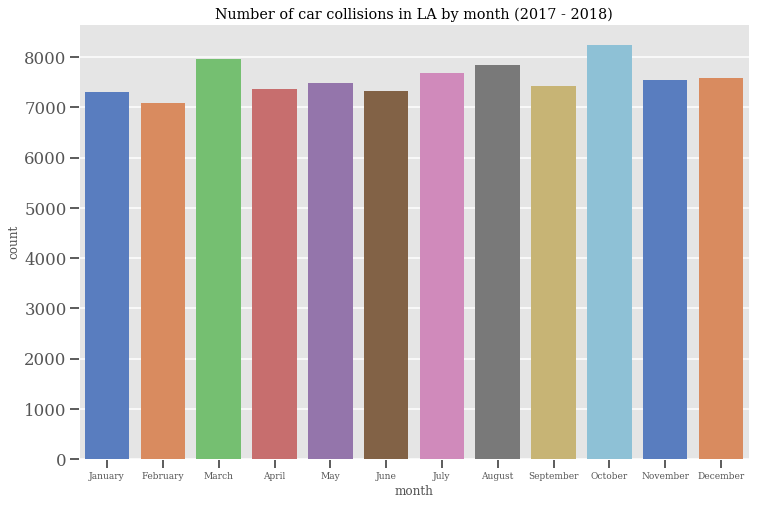

In [32]:
# Time, Collisions by month
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2017 - 2018)');

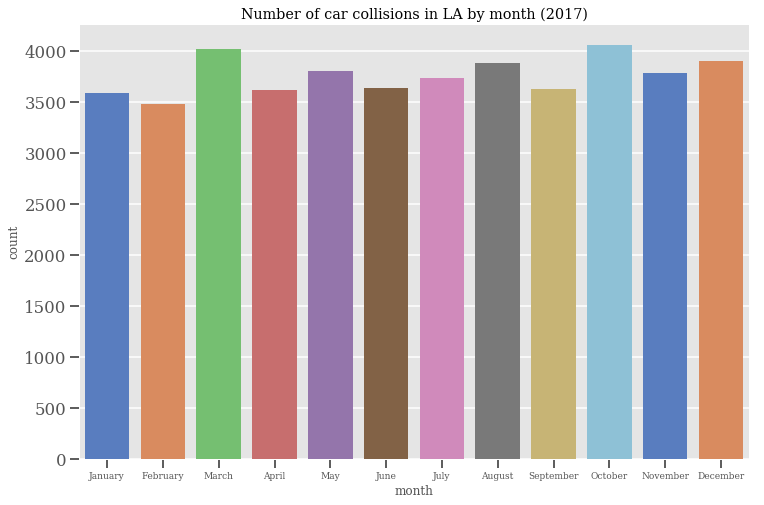

In [33]:
# Collisions by month in 2017 

fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la_2017,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2017)');



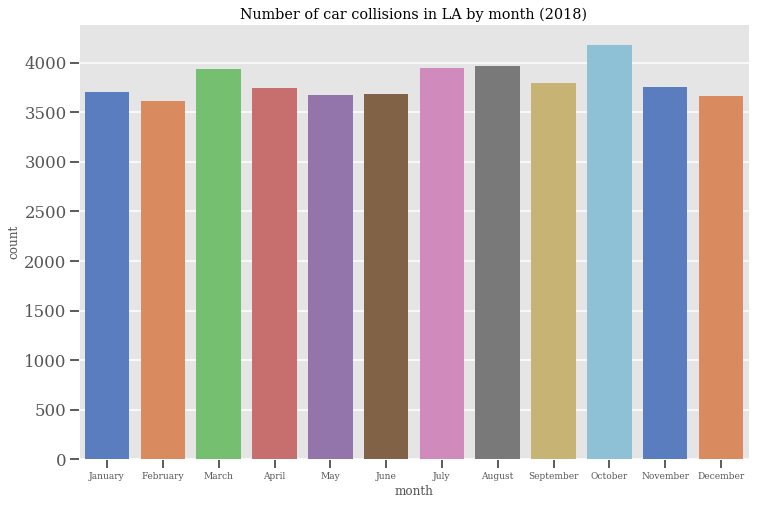

In [34]:
# Collisions by month in 2018

fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'month',data = la_2018,palette='muted')
ax.set_xticklabels(["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], fontsize=9)
ax.set_title('Number of car collisions in LA by month (2018)');

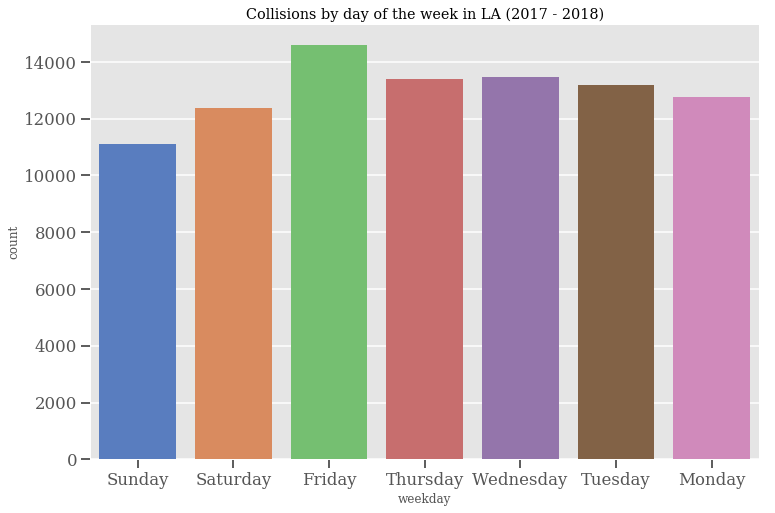

In [35]:
# collisions by weekday
fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(x = 'weekday',data = la,palette='muted')
#ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], fontsize=10)
ax.set_title('Collisions by day of the week in LA (2017 - 2018)');

# Analysis: Location

77th Street    6318
Wilshire       5465
Southwest      5439
Olympic        5046
Newton         4969
Van Nuys       4690
N Hollywood    4652
Pacific        4530
Devonshire     4519
West Valley    4478
West LA        4384
Hollywood      4271
Mission        4129
Topanga        4120
Central        4062
Southeast      3655
Northeast      3580
Hollenbeck     3252
Rampart        3247
Foothill       3187
Harbor         2852
Name: Area Name, dtype: int64

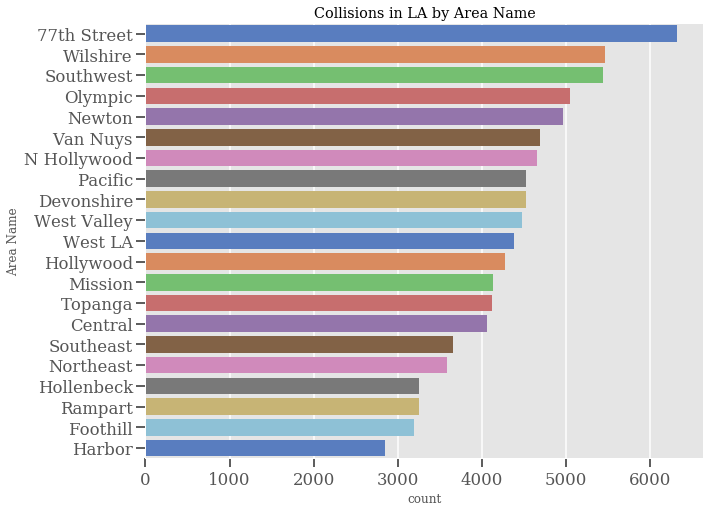

In [36]:
# collisions by area name, descending values, ORDERED

fig,ax = plt.subplots(figsize=(10,8))
descending_order = la['Area Name'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la,y="Area Name",order=descending_order, palette='muted')
ax.set_title('Collisions in LA by Area Name');

la['Area Name'].value_counts()

In [37]:
# use the Premise Description field to look at different locations of collisions, we can see that parking lot is the second most common type of collisions after street

la['Premise Description'].value_counts()

STREET                                                      86807
PARKING LOT                                                  3145
SIDEWALK                                                      328
ALLEY                                                         156
DRIVEWAY                                                      128
FREEWAY                                                        79
GAS STATION                                                    35
SINGLE FAMILY DWELLING                                         29
TRANSPORTATION FACILITY (AIRPORT)                              20
OTHER/OUTSIDE                                                  13
GARAGE/CARPORT                                                 12
PARK/PLAYGROUND                                                12
OTHER PREMISE                                                  11
PARKING UNDERGROUND/BUILDING                                   11
PEDESTRIAN OVERCROSSING                                         8
RESTAURANT

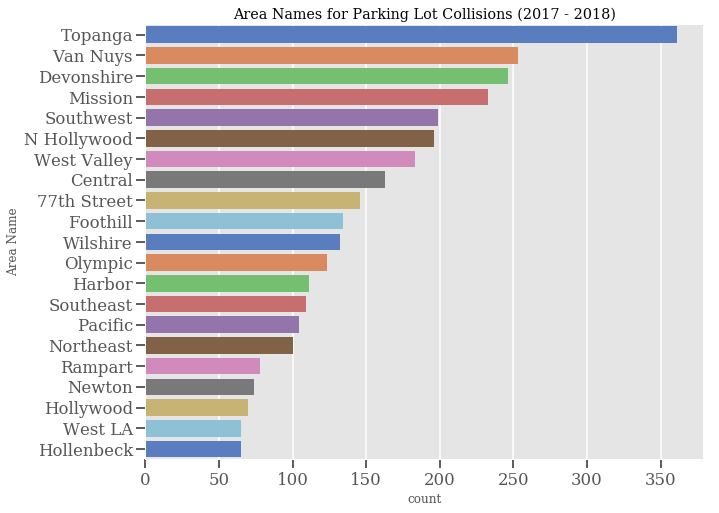

In [38]:
# Explore the area names of parking lot collisions to see if there is any commonality with the normal street collision areas

#look at parking lot only
la_parkinglot = la[la['Premise Description'] == 'PARKING LOT']

fig,ax = plt.subplots(figsize=(10,8))
descending_order = la_parkinglot['Area Name'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la_parkinglot,y="Area Name",order=descending_order, palette='muted')
ax.set_title('Area Names for Parking Lot Collisions (2017 - 2018)');

#la['Area Name'].value_counts()

14    7836
12    7718
13    7698
9     7496
7     6642
3     6287
8     6126
6     5830
4     5730
10    5628
5     5563
2     5310
11    4748
15    4338
1     3895
Name: Council Districts, dtype: int64

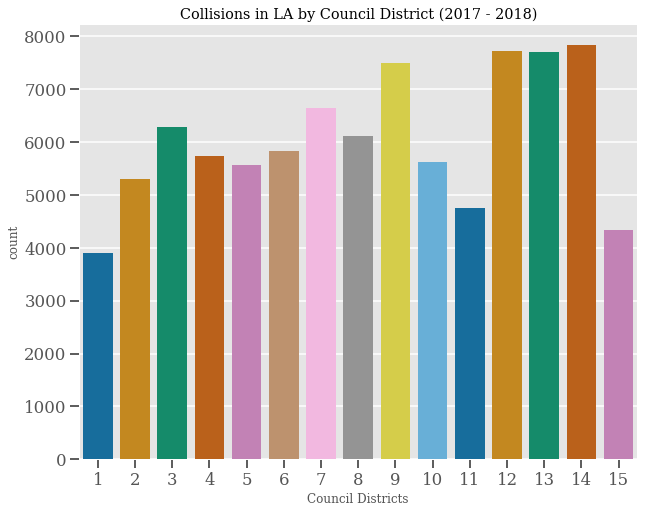

In [39]:
# Look at collisions by Council District 

fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Council Districts",data=la,palette='colorblind')
ax.set_title('Collisions in LA by Council District (2017 - 2018)');

la['Council Districts'].value_counts()

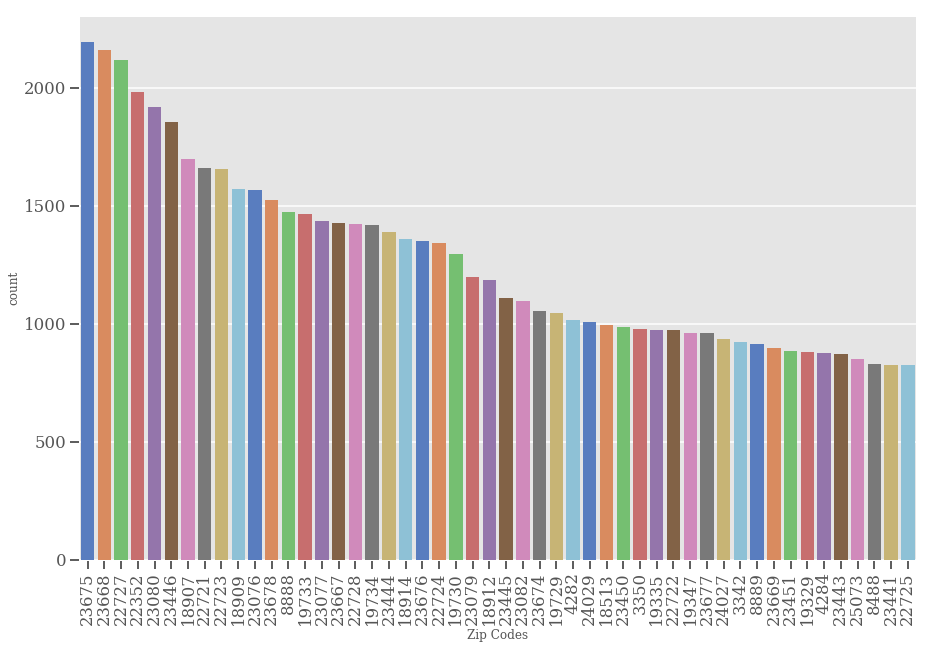

In [40]:
# Collisions by zip code

# TO DO, make top 50, descending order, add title, vertical X axis
descending_order = la['Zip Codes'].value_counts().sort_values(ascending=False).index[:50]
#sns.countplot(data=la,x="Zip Codes",order=descending_order, palette = 'muted')

#sort_values(ascending=0)[:10].plot(kind='bar')

fig,ax = plt.subplots(figsize=(15,10)), plt.xticks(rotation=90)
sns.countplot(x="Zip Codes",data=la, palette='muted', order=descending_order)
#ax.set_title('Collissions in LA by Zip Code (2017 - 2018)');

#la['Zip Codes'].value_counts()

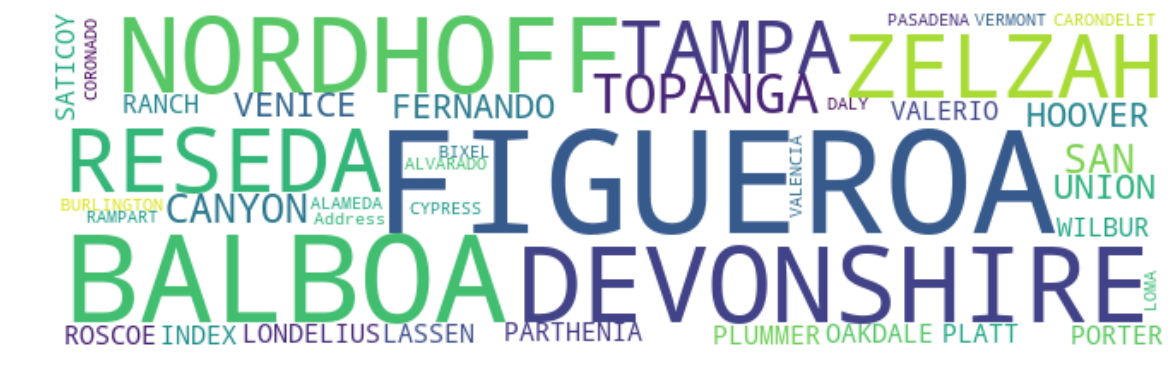

In [41]:
# Here we examine the Address streets involved in collisions

# note, the word cloud changes every time run so may not match word doc exactly

# address streets word cloud (uses 'car outline.png' for image mask)

STOPWORDS = 'dtype', 'Area', '2ND', '1ST', 'Object', '8th', 'TR', 'MAIN', 'Name', '7th', '6th', 'PL','Length', 'AV', 'ST', 'DR', 'AVENUE', 'RD', 'VIEW', 'FY', 'WY', 'BL', 'Cross', 'Street'
text = la['Address'] 
text = str(text)

#car outline.png
car_mask = np.array(Image.open(requests.get('https://www.dropbox.com/s/epiqafjhtzusok8/caroutline.png?dl=1', stream=True).raw))
#car_mask = np.array(Image.open(("/Users/johnfields/Library/Mobile Documents/com~apple~CloudDocs/Syracuse/IST652/MyPythonFiles/Project/los-angeles-traffic-collision-data/caroutline.png", stream=True.raw))
#car_mask = np.array(Image.open("caroutline.png"))
#car_mask

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
transformed_car_mask = np.ndarray((car_mask.shape[0], car_mask.shape[1]), np.int32)

wc = WordCloud(collocations=False, stopwords=STOPWORDS, background_color="white", max_words=1000, mask=transformed_car_mask, contour_width=3, contour_color='firebrick')

# Generate a wordcloud
wc.generate(text)

plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#export the file
#wc.to_file("carfinal.png")

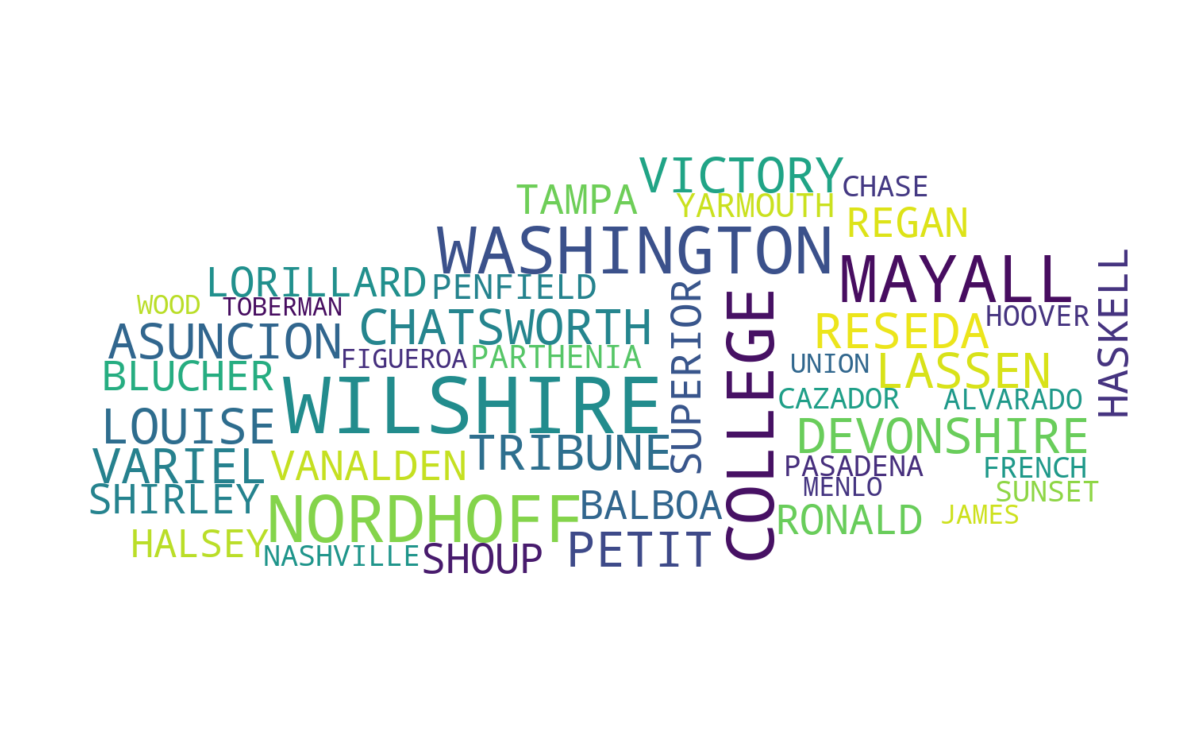

In [42]:
# Here we examine the cross streets involved in collisions

# note, the word cloud changes every time run so may not match word doc exactly

# cross streets wordcloud (uses image 'whitecar.png' for image mask)

STOPWORDS = 'dtype', 'Area', '2ND', '1ST', 'Object', '8th', 'MAIN', 'Name', '7th', '6th', 'PL','Length', 'AV', 'ST', 'DR', 'AVENUE', 'RD', 'VIEW', 'FY', 'WY', 'BL', 'Cross', 'Street'
text = str(la['Cross Street'])

#mask = np.array(Image.open("whitecar.png"))
mask = np.array(Image.open(requests.get('https://www.dropbox.com/s/yag9o4komljn5yx/whitecar.png?dl=1', stream=True).raw))
#mask = np.array(Image.open("/Users/johnfields/Library/Mobile Documents/com~apple~CloudDocs/Syracuse/IST652/MyPythonFiles/Project/los-angeles-traffic-collision-data/whitecar.png"))
wc = WordCloud(stopwords= STOPWORDS, background_color="white", max_words=1000, mask=mask,
               max_font_size=100, random_state=10)
wc.generate(text)

# create coloring from image mask
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20])
plt.imshow(wc, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
_=plt.show()

# Analysis: Demographics

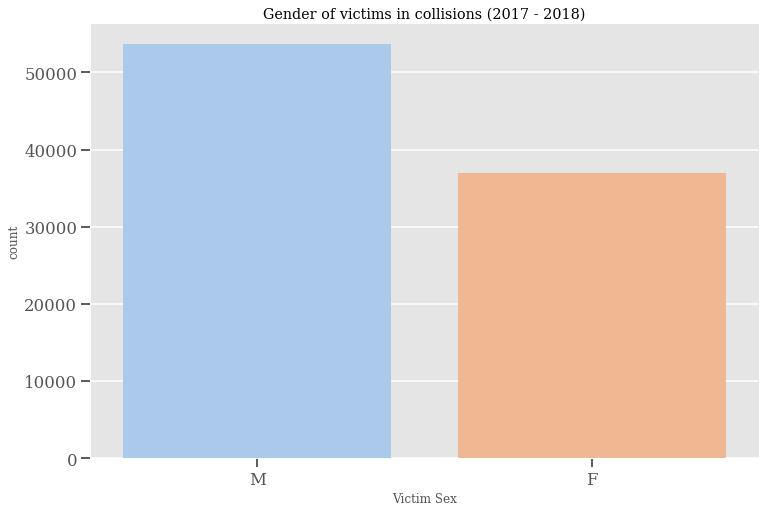

In [43]:
# Collision by gender

fig,ax = plt.subplots(figsize=(12,8))
sns.countplot(data=la,x="Victim Sex",palette='pastel', order=la['Victim Sex'].value_counts().iloc[:2].index)
ax.set_title('Gender of victims in collisions (2017 - 2018)');

In [0]:
# here different subsets of ethnicties and genders were made in order to make it easier to analyze across genders and ethnicties

#Make demographic subdata sets

#filter by race

la_asian = la[la['Victim Descent']== "A"]
la_hispanic = la[la['Victim Descent']== "H"]
la_black = la[la['Victim Descent']== "B"]
la_white = la[la['Victim Descent']== "W"]

#filter by victim sex

#la_women = la[la['Victim Sex'] == "F"]
#la_men = la[la['Victim Sex']=="M"]

#sex and race

#asian_women = la_women.merge(la_asian, how='inner', on=['Victim Sex'])
#asian_men = la_men.merge(la_asian, how='inner', on=['Victim Sex'])
#black_men = la_men.merge(la_black, how='inner', on=['Victim Sex'])
#black_women = la_women.merge(la_black, how='inner', on=['Victim Sex'])
#white_men = la_men.merge(la_white, how='inner', on=['Victim Sex'])
#white_women = la_women.merge(la_white, how='inner', on=['Victim Sex'])
#hispanic_men = la_men.merge(la_hispanic, how='inner', on=['Victim Sex'])
#hispanic_women = la_women.merge(la_hispanic, how='inner', on=['Victim Sex'])



In [45]:
# black males vs females
la_black['Victim Sex'].value_counts()

# black male and female distribution fairly even

M    7121
F    6400
H       6
X       1
N       1
Name: Victim Sex, dtype: int64

In [46]:
# asian males vs females
la_asian['Victim Sex'].value_counts() 

# we can see that asian male and female distribution is fairly even

M    2023
F    1704
H       1
N       1
X       1
Name: Victim Sex, dtype: int64

In [47]:
# hispanic males vs females
la_hispanic['Victim Sex'].value_counts() 

# we can see that more hispanic males compared to hispanic women

M    22739
F    14910
X        4
H        3
N        1
Name: Victim Sex, dtype: int64

In [48]:
# white males vs females
la_white['Victim Sex'].value_counts()

# we can see that more white males compared to white females

M    12223
F     8258
H        2
N        1
Name: Victim Sex, dtype: int64

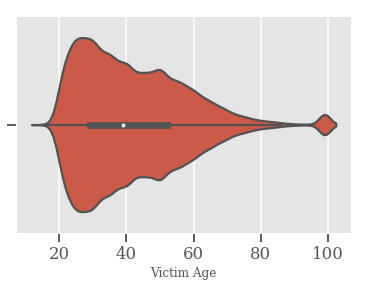

In [49]:
# Victim age violin plot
#sns.violinplot(x="rank", y="senitment", hue="category", data=df)
sns.violinplot(x='Victim Age', data=la)
#ax.set_title('Victim Age Distribution (2017 - 2018)')

In [50]:
# Victim's Ages
la['Victim Age'].describe()

count    90845.000000
mean        41.809720
std         16.156667
min         15.000000
25%         29.000000
50%         39.000000
75%         52.000000
max         99.000000
Name: Victim Age, dtype: float64

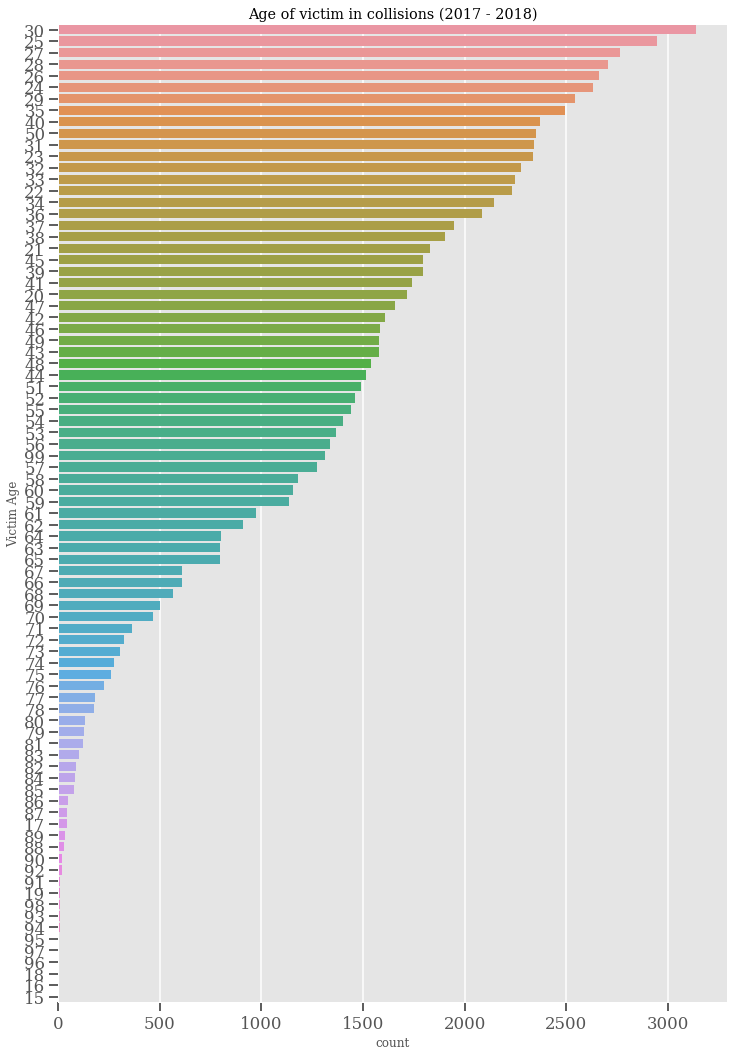

In [51]:
# Age sorted by collision 


fig,ax = plt.subplots(figsize=(12,18))
descending_order = la['Victim Age'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la,y="Victim Age",order=descending_order)
ax.set_title('Age of victim in collisions (2017 - 2018)');

In [52]:
#bin victim ages

la['age_by_decade'] = pd.cut(x=la['Victim Age'], bins=[19,29,39,49,59,69,79], labels=['20s','30s','40s','50s','60s','70s'])
la.age_by_decade.head()

4920    70s
4921    20s
4922    30s
4923    50s
4924    20s
Name: age_by_decade, dtype: category
Categories (6, object): [20s < 30s < 40s < 50s < 60s < 70s]

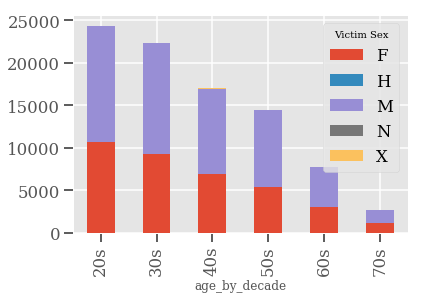

In [53]:
# age by decade and gender
la.groupby(['age_by_decade','Victim Sex']).size().unstack().plot(kind='bar',stacked=True)

# here we can see that men are larger in every decade except the 70s where it is even

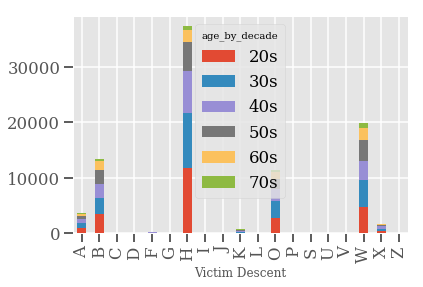

In [54]:
# Create bar chart by Victim Race and Age by Decade
la.groupby(['Victim Descent','age_by_decade']).size().unstack().plot(kind='bar',stacked=True)
plt.show()


Text(0, 0.5, 'Density')

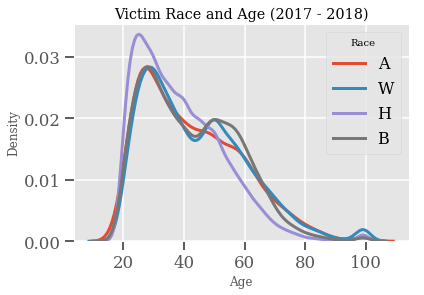

In [55]:
# race by age breakdown

# List of races to plot
races = ['A', 'W', 'H', 'B' ]

# Iterate through 
for race in races:
    subset = la[la['Victim Descent'] == race]
    
    # Draw the density plot
    sns.distplot(subset['Victim Age'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = race)
    

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Race and Age (2017 - 2018)')
plt.xlabel('Age')
plt.ylabel('Density')

In [56]:
# breakdown of victim races (2017 - 2018)
la['Victim Descent'].value_counts()

H    37657
W    20484
B    13529
O    12256
A     3730
X     1820
K      717
F      285
C      126
U       48
J       42
Z       35
V       35
P       30
I       29
G       12
S        5
D        4
L        1
Name: Victim Descent, dtype: int64

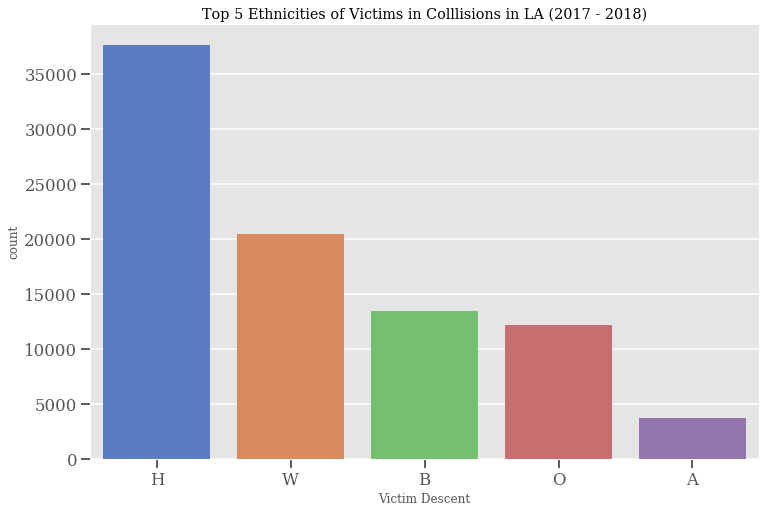

In [57]:
# Victims
# variables with very little count were ommitted, top 5 displayed
fig,ax = plt.subplots(figsize=(12,8))

descending_order = la['Victim Descent'].value_counts().sort_values(ascending=False).index
sns.countplot(data=la,x="Victim Descent", palette = 'muted',  order=la['Victim Descent'].value_counts().iloc[:5].index)
ax.set_title('Top 5 Ethnicities of Victims in Colllisions in LA (2017 - 2018)');

In [58]:
# get percentages of victim descent (in order to prep for donut charts)

la['Victim Descent'].value_counts(normalize=True) * 100

H    41.451924
W    22.548297
B    14.892399
O    13.491111
A     4.105895
X     2.003412
K     0.789256
F     0.313721
C     0.138698
U     0.052837
J     0.046233
Z     0.038527
V     0.038527
P     0.033023
I     0.031923
G     0.013209
S     0.005504
D     0.004403
L     0.001101
Name: Victim Descent, dtype: float64

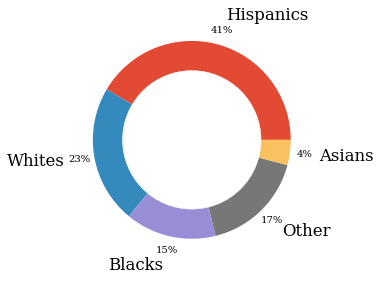

In [59]:
# victim descent donut chart  

# library
import matplotlib.pyplot as plt
 
# Data
names='Hispanics', 'Whites', 'Blacks', 'Other', 'Asians',
size=[41.47, 22.56, 14.86, 17, 4.11]
 
# create a figure and set different background
fig = plt.figure()
fig.patch.set_facecolor('white')
 
# Change color of text
plt.rcParams['text.color'] = 'black'
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
 
# Pieplot + circle on it
plt.pie(size, labels=names, autopct='%1.0f%%', pctdistance=1.15, labeldistance=1.3)
p=plt.gcf()
p.gca().add_artist(my_circle) 
plt.tight_layout()
#plt.title('Victim Ethnicities (2017 - 2018)', y=-0.01)


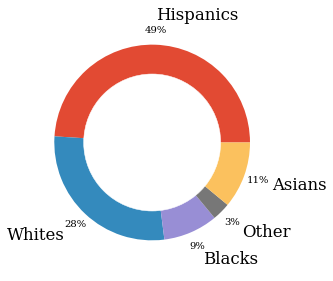

In [60]:
# victim descent donut chart for LA population in general, percentages are in the size variable 

# library
import matplotlib.pyplot as plt
 
# Data
names='Hispanics', 'Whites', 'Blacks', 'Other', 'Asians',
size=[49, 28, 9, 3, 11]
 
# create a figure and set different background
fig = plt.figure()
fig.patch.set_facecolor('white')
 
# Change color of text
plt.rcParams['text.color'] = 'black'
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
 
# Pieplot + circle on it
plt.pie(size, labels=names, autopct='%1.0f%%', pctdistance=1.15, labeldistance=1.3)
p=plt.gcf()
p.gca().add_artist(my_circle) 
plt.tight_layout()
#plt.title('Victim Ethnicities (2017 - 2018)', y=-0.01)

Text(0, 0.5, 'Density')

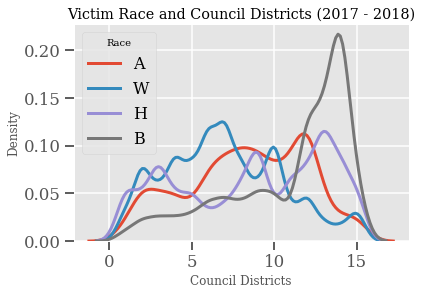

In [61]:
# race by council district breakdown

# List of races to plot
airlines = ['A', 'W', 'H', 'B' ]




# Iterate through 
for race in races:
    subset = la[la['Victim Descent'] == race]
    
# Draw density plot
    sns.distplot(subset['Council Districts'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = race)
    

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Race and Council Districts (2017 - 2018)')
plt.xlabel('Council Districts')
plt.ylabel('Density')

In [0]:
# Race and income breakdown 

#la.groupby(['Victim Descent', 'Median Income']).size()

Text(0, 0.5, 'Density')

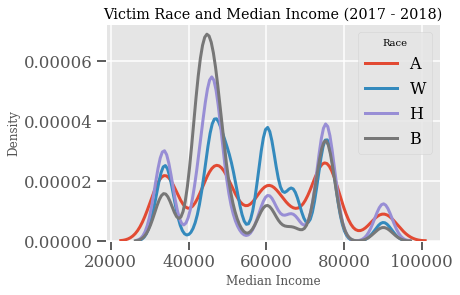

In [63]:
# income and race breakdown

# List of races to plot
airlines = ['A', 'W', 'H', 'B' ]

# Iterate through
for race in races:
    subset = la[la['Victim Descent'] == race]
    
# Draw the density plot
    sns.distplot(subset['Median Income'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = race)
    

# Plot formatting
plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Race and Median Income (2017 - 2018)')
plt.xlabel('Median Income')
plt.ylabel('Density')

Text(0.5, 1.0, 'Victim Descent and Median Income (2017 - 2018)')

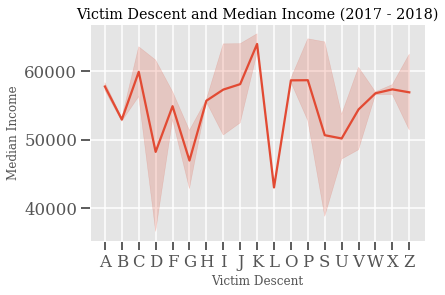

In [64]:
# line chart for victim race and income

#sns.lineplot(x="timepoint", y="signal", data=fmri)

sns.lineplot(x='Victim Descent', y='Median Income', data=la, markers=True, dashes=False)

#plot formatting 
#plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Descent and Median Income (2017 - 2018)')


Text(0.5, 1.0, 'Victim Age and Median Income (2017 - 2018)')

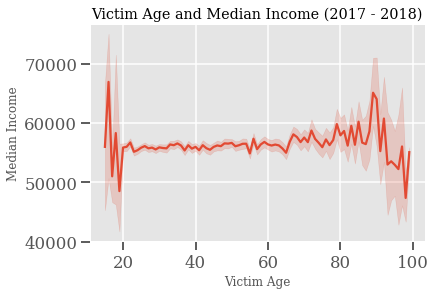

In [65]:
# line chart for victim race and income

#sns.lineplot(x="timepoint", y="signal", data=fmri)

sns.lineplot(x='Victim Age', y='Median Income', data=la)

#plot formatting 
#plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Age and Median Income (2017 - 2018)')

Text(0.5, 1.0, 'Victim Race and Median Income (2017 - 2018)')

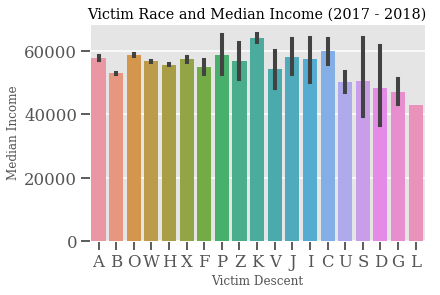

In [66]:
# barplot for victim race and income

#sns.lineplot(x="timepoint", y="signal", data=fmri)

#Victim income scatterplot

#ax = sns.scatterplot(x="total_bill", y="tip", hue="time",data=tips)

sns.barplot(y='Median Income', x='Victim Descent', data=la)
#plot formatting 
#plt.legend(prop={'size': 16}, title = 'Race')
plt.title('Victim Race and Median Income (2017 - 2018)')

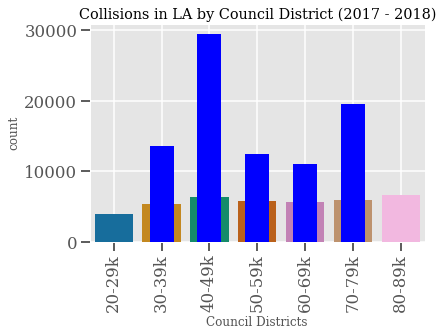

In [67]:
# make bins of Median Income

import matplotlib
plt.style.use('ggplot')
#df_ages['age_bins'] = pd.cut(x=df_ages['age'], bins=[20, 29, 39, 49])
la['income_bins'] = pd.cut(x=la['Median Income'], bins=[20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000], labels=['20-29k', '30-39k', '40-49k', '50-59k', '60-69k', '70-79k', '80-89k'])
#la['Median Income'].round(0)
#la['Median Income'].astype(int)

#la.income_bins.head()



#width = 0.35       
#a = la.groupby('income_bins').size()
#plt.bar(la, a, width, label='Normal')

fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x="Council Districts",data=la,palette='colorblind')
ax.set_title('Collisions in LA by Council District (2017 - 2018)')

ax = la['income_bins'].value_counts(sort=False).plot.bar(rot=0, color='b', figsize=(6,4)), plt.xticks(rotation=90)
#ax.set_xticklabels([c[1:-1].replace(","," to") for c in la['income_bins'].cat.categories])
plt.show()
#ax.set_title('Median Income Binned (2017 - 2018)')
#sns.countplot(data=la,x="Median Income", palette = 'muted',  order=la['Median Income'].value_counts().iloc[:5].index)

Text(0.5, 1.0, 'Income Distribution of Colission Victims (2017 - 2018)')

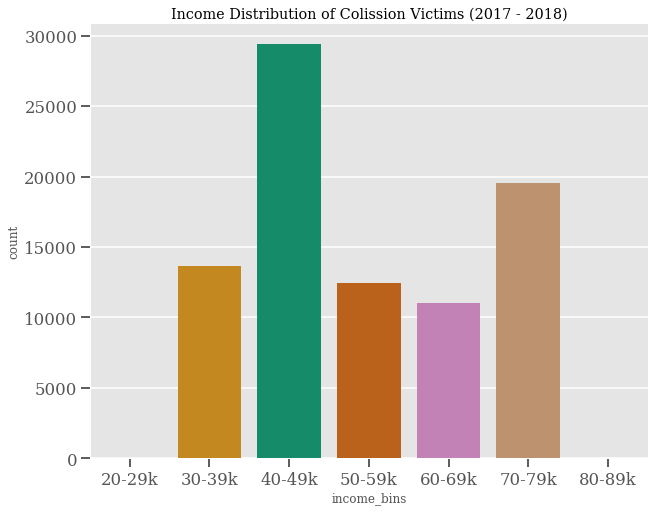

In [68]:
# Income Distribution of colission victims

fig,ax = plt.subplots(figsize=(10,8))
sns.countplot(x="income_bins",data=la,palette='colorblind')
ax.set_title('Income Distribution of Colission Victims (2017 - 2018)')




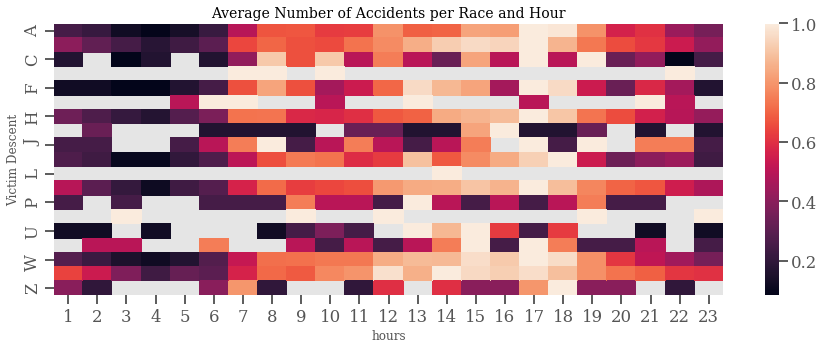

In [69]:
# accidents by race per hour

accidents_hour_pt = la.pivot_table(index='Victim Descent', columns='hours', aggfunc='size')
accidents_hour_pt = accidents_hour_pt.apply(lambda x: x / accidents_hour_pt.max(axis=1))
plt.figure(figsize=(15,5))
plt.title('Average Number of Accidents per Race and Hour', fontsize=14)
sns.heatmap(accidents_hour_pt, cbar=True, annot=False, fmt=".0f");

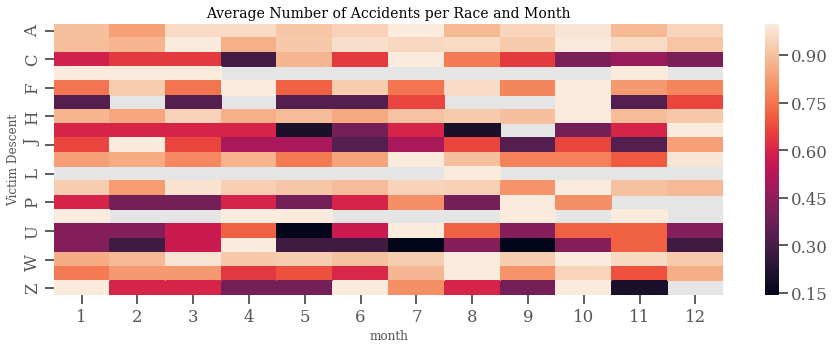

In [70]:
# accidents by race per month
accidents_month_pt = la.pivot_table(index='Victim Descent', columns='month', aggfunc='size')
accidents_month_pt = accidents_month_pt.apply(lambda x: x / accidents_month_pt.max(axis=1))
plt.figure(figsize=(15,5))
plt.title('Average Number of Accidents per Race and Month', fontsize=14)
sns.heatmap(accidents_month_pt, cbar=True, annot=False, fmt=".0f");

#Analysis: Time and Location

Summary of top VictimSex occurences 

M    35342
F    26517
X      154
H       11
N        2
Name: VictimSex, dtype: int64
Summary of top VictimSex occurences 

M    17446
F     9824
X       75
H        6
N        4
Name: VictimSex, dtype: int64
Proportion of each VictimDescent in collisions during day
A    0.703512
B    0.688655
C    0.772358
D    0.750000
F    0.727599
G    0.583333
H    0.684384
I    0.793103
J    0.666667
K    0.734752
L    1.000000
O    0.676093
P    0.814815
S    0.500000
U    0.833333
V    0.588235
W    0.725231
X    0.648739
Z    0.714286
Name: VictimDescent, dtype: float64
Proportion of each VictimDescent in collisions during day
A    0.296488
B    0.311345
C    0.227642
D    0.250000
F    0.272401
G    0.416667
H    0.315616
I    0.206897
J    0.333333
K    0.265248
L         NaN
O    0.323907
P    0.185185
S    0.500000
U    0.166667
V    0.411765
W    0.274769
X    0.351261
Z    0.285714
Name: VictimDescent, dtype: float64
CrossStreets with the most collisi

Text(0.5, 1.0, 'Collisions 2017 Jan.')

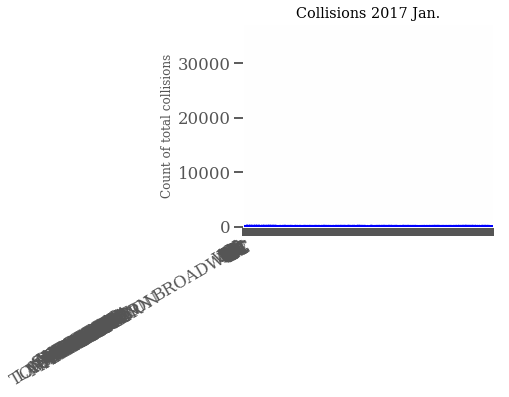

In [71]:
# Time and Location Analysis Maps printed to directory

la1 = la.merge(weather, how='inner', on=['Date'], sort=True)


la1.drop(["Unnamed: 0"], axis= 1, inplace=True) #space in unnamed
la1.drop(['Location'], axis=1 , inplace=True)
la1 = la1.rename(columns = lambda col: col.replace(" ", ""))
#la1 = la.copy()
la1.head()

la1['NauticalTwilightRise'] = pd.to_datetime(la1['NauticalTwilightRise'], format='%H:%M').dt.hour#

# put NauticalTwilightSet into integer add 12 to it then put into date time

#add PM to NauticalTwilightSet

la1['NauticalTwilightSet'] = la1['NauticalTwilightSet'] + " PM"


la1['NauticalTwilightSet'] = pd.to_datetime(la1['NauticalTwilightSet'], format='%H:%M %p').dt.hour#


la1['NauticalTwilightSet'] = la1['NauticalTwilightSet'] + 12
#adding PM to each row



la1['TimeOccurred'].value_counts().plot(kind='bar')
plt.title("Collisions by Time of Day")
plt.tight_layout()

def vc_fun(df, column_name, *args):
    '''

    :param df: dataframe
    :param column_name: A STRING - a column to value_counts
    :param args: if args then add .nlargest()  enter a number for how many largest
    :return: print value counts summary
    '''
    if args:
        print("Summary of top " + column_name + " occurences \n")
        print(df[column_name].value_counts().nlargest(args[0]))
    else:
        print("Summary of top " + column_name + " occurences \n")
        print(df[column_name].value_counts())



sunny_days = (la1['TimeOccurred'] > la1['NauticalTwilightRise']) & (la1['TimeOccurred'] < la1['NauticalTwilightSet'])

sunny_df = la1.loc[sunny_days == True]

vc_fun(sunny_df, 'VictimSex')

sunny_df['VictimSex'].value_counts().plot(kind='bar')
plt.title("VictimSex counts during day light")


night_df = la1.loc[sunny_days == False]

vc_fun(night_df, 'VictimSex')

#proportion of each VictimDescent in collisions during day / night

print("Proportion of each VictimDescent in collisions during day")

print(sunny_df['VictimDescent'].value_counts()/la1['VictimDescent'].value_counts())

(sunny_df['VictimDescent'].value_counts()/la1['VictimDescent'].value_counts()).plot(kind='bar')

plt.title("Proportion of VictimDescent in DayTime Collisions")


print("Proportion of each VictimDescent in collisions during day")
print(night_df['VictimDescent'].value_counts()/la1['VictimDescent'].value_counts())


(night_df['VictimDescent'].value_counts()/la1['VictimDescent'].value_counts()).plot(kind='bar')
plt.title("Proportion of VictimDescent in NightTime Collisions")

print("CrossStreets with the most collision \n")
print(la['Cross Street'].value_counts()[la['Cross Street'].value_counts() > 500])

la1['CrossStreet'].value_counts()[la1['CrossStreet'].value_counts() > 500].plot(kind='bar')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.title("CrossStreets with the highest collision totals")

print("Addresses with the most collisions \n")
print(la['Address'].value_counts()[la['Address'].value_counts() >500])


la['Address'].value_counts()[la['Address'].value_counts() > 500].plot(kind='bar')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.title("Address with the highest collision totals")


def get_coords(df):
    '''

    :param df: dataframe with coordinates listed as latitude and longitude
    :return: list of tuples lat and lon
    '''
    coords = list(zip(df.latitude, df.longitude))
    return coords

def map_LAcoords(tuple_list, size, desired_file_name, type):
    '''

    :param tuple_list: a list of tuples
    :param size: for heat map. always specify number
    :param desired_file_name: file name you want
    :param type: 'heat' or 'Heat' will make a heat map. specify something else for points
    :return: plots a map of LA with given coordinates in heatmap
    '''
    the_map = folium.Map(location=(34.052235,-118.243683))
    if type == 'heat' or type == 'Heat':
        HeatMap(tuple_list, radius=size).add_to(the_map)
        the_map.save(desired_file_name + "map.html")
    else:
        for coord in tuple_list:
            folium.Marker(coord).add_to(the_map)
        the_map.save(desired_file_name + "map.html")


coordSunny = get_coords(sunny_df)

#make the map save it
map_LAcoords(coordSunny, 13, 'SunnyCrash', 'heat')

#make mape and save it
coordNight = get_coords(night_df)

map_LAcoords(coordNight, 13, 'NightCrash', 'heat')

#Analyze day of the week by time.

#which days had the most crashes


vc_fun(la1, 'Date', 10)

vc_fun(la1, 'month', 5) #which months had the most crashes

vc_fun(la1, 'weekday') #which weekday had the most crashes

vc_fun(la1, 'AverageTemp', 10) #top 10 most occurring temperatures in collisions

vc_fun(la1, 'HighTemp', 10)

vc_fun(la1, 'LowTemp', 10) # summary of top Low temp occurences

vc_fun(la1, 'Precipitation', 10)


print("Top 8 CrossStreets and Address by collision counts \n")

print(la1.groupby(['CrossStreet', 'Address']).size().nlargest(8))

cros_and_add = la1.groupby(['CrossStreet', 'Address']).size() > 45
print("The Streets with the most accidents \n")
print(la1.groupby(['CrossStreet', "Address"]).size().nlargest(8))

cross_add = la1.groupby(['CrossStreet', "Address"]).size() >= 46
la2 = la1.copy()

la2.set_index(['CrossStreet', 'Address'], inplace=True)

cross_add = la2.loc[cross_add]

cross_add_coords = get_coords(cross_add)

len(cross_add_coords) # 413 points.


map_LAcoords(cross_add_coords,13, 'CrossStreets&Address', 'point')

#time series

time_series1 = la1['Date'].value_counts()

ax = time_series1.plot(color="blue")
#plt.show() = shows plot
ax.set_ylabel("Count of total collisions")
ax.set_title('Crashes by time')


la.reset_index(inplace = True)

series_dates = la['Date'].value_counts()

la.set_index('Date', inplace = True)

time_series1 = la['2017-01-01':'2017-04-05']

la.reset_index(inplace= True)

time_series1.reset_index(inplace= True)

counts1 = time_series1['Date'].value_counts()

ax = counts1.plot(color='blue')

tick_spacing = 7 # for each week

ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))






# 1/8 to 2/12 to look for day of the week patterns
la.set_index('Date', inplace= True)
time_series1 = la['2017-01-08': '2017-02-08']
la.reset_index(inplace=True)
time_series1.reset_index(inplace=True)

counts1 = time_series1['Date'].value_counts()


ax = counts1.plot(color="blue")

days = matplotlib.dates.DayLocator()

ax.xaxis.set_major_locator(days)

ax.set_title("Collisions 2017 Jan.")



#la1['CrossStreet'] = la1['CrossStreet'].apply(lambda x: x.split())



#la2['Date'] = la2['Date'].dt.date




In [72]:
la1.head()

,TimeOccurred,AreaName,VictimAge,VictimSex,VictimDescent,PremiseDescription,Address,CrossStreet,ZipCodes,CouncilDistricts,MedianIncome,Date,year,month,weekday,hours,longitude,latitude,age_by_decade,income_bins,HighTemp,LowTemp,AverageTemp,Precipitation,NauticalTwilightRise,NauticalTwilightSet
0,15,Devonshire,26,F,W,STREET,TOPANGA CANYON BL,TULSA ST,4284,2,61000.0,2017-01-01,2017,1,Sunday,15,-118.6061,34.2663,20s,60-69k,55,39,47,0.0,6,17
1,3,Northeast,23,F,H,STREET,FLETCHER DR,E DELAY DR,24030,8,34300.0,2017-01-01,2017,1,Sunday,3,-118.2435,34.1165,20s,30-39k,55,39,47,0.0,6,17
2,21,Hollywood,24,F,W,STREET,HIGHLAND AV,DE LONGPRE AV,23446,8,34300.0,2017-01-01,2017,1,Sunday,21,-118.3386,34.0962,20s,30-39k,55,39,47,0.0,6,17
3,3,Hollywood,51,F,H,STREET,LEXINGTON AV,WESTERN AV,23447,8,34300.0,2017-01-01,2017,1,Sunday,3,-118.3092,34.0928,50s,30-39k,55,39,47,0.0,6,17
4,2,Hollywood,59,F,K,STREET,SUNSET,VINE,23446,8,34300.0,2017-01-01,2017,1,Sunday,2,-118.3267,34.0980,50s,30-39k,55,39,47,0.0,6,17


In [73]:
la1.columns

Index(['TimeOccurred', 'AreaName', 'VictimAge', 'VictimSex', 'VictimDescent',
       'PremiseDescription', 'Address', 'CrossStreet', 'ZipCodes',
       'CouncilDistricts', 'MedianIncome', 'Date', 'year', 'month', 'weekday',
       'hours', 'longitude', 'latitude', 'age_by_decade', 'income_bins',
       'HighTemp', 'LowTemp', 'AverageTemp', 'Precipitation',
       'NauticalTwilightRise', 'NauticalTwilightSet'],
      dtype='object')

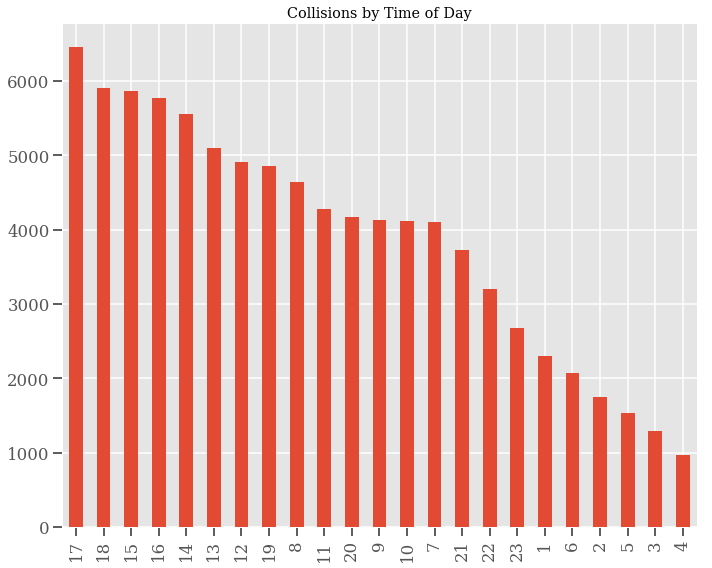

In [74]:

fig,ax = plt.subplots(figsize=(10,8))

la1['TimeOccurred'].value_counts().plot(kind='bar')
plt.title("Collisions by Time of Day")
plt.tight_layout()

Text(0.5, 1.0, 'VictimSex counts during day light')

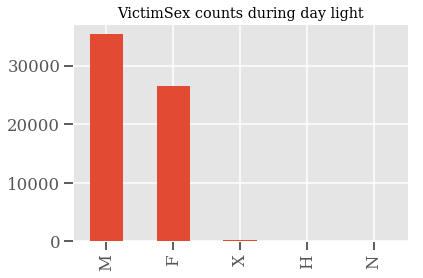

In [75]:

sunny_df['VictimSex'].value_counts().plot(kind='bar')
plt.title("VictimSex counts during day light")


Text(0.5, 1.0, 'Proportion of VictimDescent in DayTime Collisions')

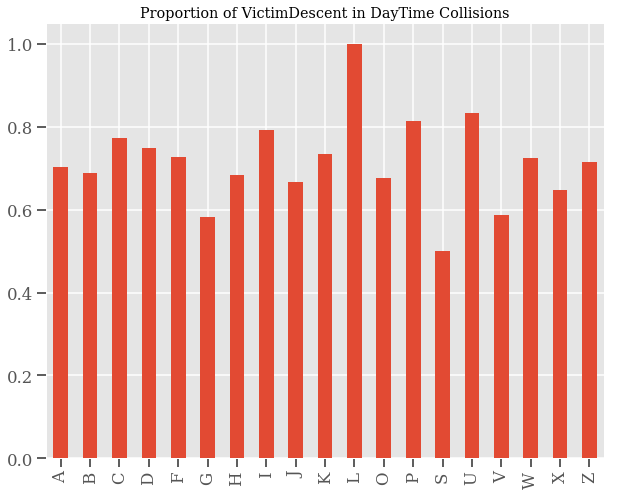

In [76]:

fig,ax = plt.subplots(figsize=(10,8))
(sunny_df['VictimDescent'].value_counts()/la1['VictimDescent'].value_counts()).plot(kind='bar')

plt.title("Proportion of VictimDescent in DayTime Collisions")

Text(0.5, 1.0, 'Proportion of VictimDescent in NightTime Collisions')

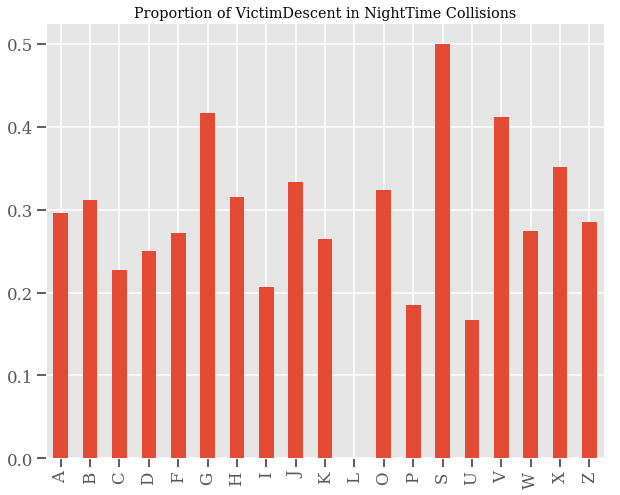

In [77]:

fig,ax = plt.subplots(figsize=(10,8))

(night_df['VictimDescent'].value_counts()/la1['VictimDescent'].value_counts()).plot(kind='bar')
plt.title("Proportion of VictimDescent in NightTime Collisions")

In [78]:
# collisions by address street
la['Address'].value_counts()

WESTERN                      AV       1322
SHERMAN                      WY       1242
VENTURA                      BL       1239
VICTORY                      BL       1129
SEPULVEDA                    BL       1120
VERMONT                      AV       1083
FIGUEROA                     ST       1053
ROSCOE                       BL        938
VANOWEN                      ST        900
OLYMPIC                      BL        888
VAN NUYS                     BL        876
SUNSET                       BL        834
PICO                         BL        788
BROADWAY                               729
NORMANDIE                    AV        701
WILSHIRE                     BL        696
VENICE                       BL        661
LAUREL CANYON                BL        634
CENTRAL                      AV        622
WASHINGTON                   BL        613
FLORENCE                     AV        594
3RD                          ST        576
LA BREA                      AV        572
TOPANGA CAN

In [79]:
# collisions by cross street
la['Cross Street'].value_counts()

VERMONT                      AV       740
FIGUEROA                     ST       674
WESTERN                      AV       634
SHERMAN                      WY       612
VICTORY                      BL       587
SEPULVEDA                    BL       577
BROADWAY                              561
VANOWEN                      ST       558
ROSCOE                       BL       515
PICO                         BL       512
3RD                          ST       502
MAIN                         ST       491
NORMANDIE                    AV       488
VAN NUYS                     BL       474
OLYMPIC                      BL       470
6TH                          ST       433
WASHINGTON                   BL       429
CENTRAL                      AV       428
VENICE                       BL       425
SATICOY                      ST       414
HOOVER                       ST       411
BURBANK                      BL       405
8TH                          ST       396
NORDHOFF                     ST   

Text(0.5, 1.0, 'CrossStreets with the highest collision totals')

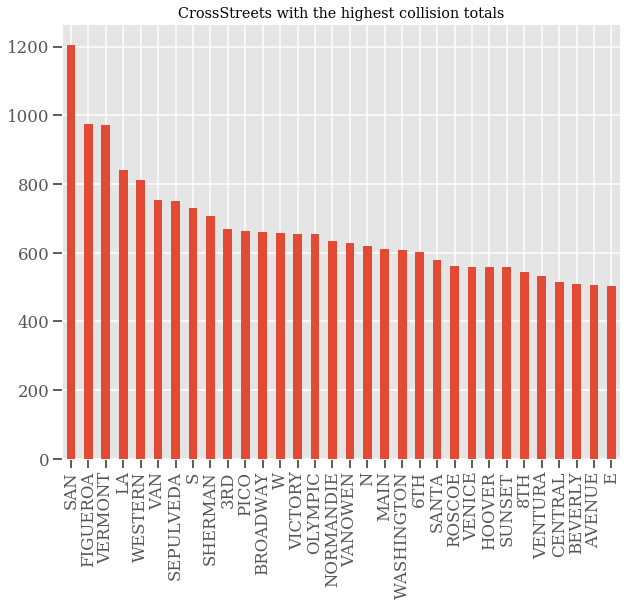

In [80]:
la_cop = la.copy()



la_cop['Cross Street'] = la_cop['Cross Street'].apply(lambda x: x.split(" ")[0])


fig,ax = plt.subplots(figsize=(10,8))

la_cop['Cross Street'].value_counts()[la_cop['Cross Street'].value_counts() > 500].plot(kind='bar')
#plt.xticks(rotation = 45)
#plt.tight_layout()
plt.title("CrossStreets with the highest collision totals")

Text(0.5, 1.0, 'Address with the highest collision totals')

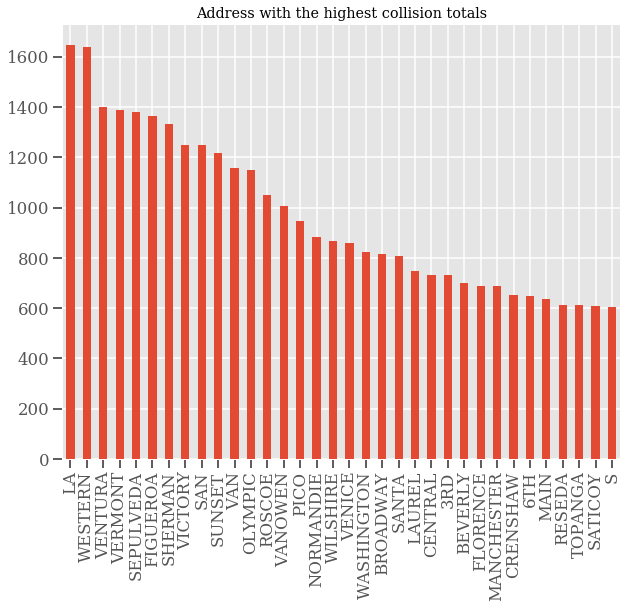

In [81]:
#la_cop = la.copy()



la_cop['Address'] = la_cop['Address'].apply(lambda x: x.split(" ")[0])




fig,ax = plt.subplots(figsize=(10,8))
la_cop['Address'].value_counts()[la_cop['Address'].value_counts() > 600].plot(kind='bar')
#plt.xticks(rotation = 45)
#plt.tight_layout()
plt.title("Address with the highest collision totals")

In [82]:
cross_add

TimeOccurred  ... NauticalTwilightSet
CrossStreet                     Address                                        ...                    
NORDHOFF                     ST TAMPA                        AV            13  ...                  17
SEPULVEDA                    BL SHERMAN                      WY            20  ...                  17
RODEO                        RD LA BREA                      AV            16  ...                  17
VICTORY                      BL TOPANGA CANYON               BL            15  ...                  18
                                TOPANGA CANYON               BL            18  ...                  18
WHITSETT                     AV SHERMAN                      WY             1  ...                  18
                                SHERMAN                      WY            10  ...                  18
WOODMAN                      AV SHERMAN                      WY             2  ...                  18
NORDHOFF                     ST TAMPA                        AV            12  ...                  18
WHITSETT                     AV SHERMAN                      WY            10  ...                  18
                                SHERMAN                      WY            22  ...                  18
RODEO                        RD LA BREA                      AV            15  ...                  18
WHITSETT                     AV SHERMAN                      WY            18  ...                  18
NORDHOFF                     ST TAMPA                        AV            18  ...                  18
RODEO                        RD LA BREA                      AV            20  ...                  18
SEPULVEDA                    BL BURBANK                      BL            18  ...                  18
WHITSETT                     AV SHERMAN                      WY            13  ...                  18
WOODMAN                      AV SHERMAN                      WY             1  ...                  18
SEPULVEDA                    BL SHERMAN                      WY            12  ...                  18
                                SHERMAN                      WY            16  ...                  18
WHITSETT                     AV SHERMAN                      WY            12  ...                  18
WOODMAN                      AV SHERMAN                      WY            15  ...                  18
WHITSETT                     AV SHERMAN                      WY            12  ...                  18
SEPULVEDA                    BL BURBANK                      BL            14  ...                  18
                                SHERMAN                      WY            12  ...                  18
WOODMAN                      AV SHERMAN                      WY            23  ...                  18
SEPULVEDA                    BL BURBANK                      BL             6  ...                  18
VICTORY                      BL TOPANGA CANYON               BL            14  ...                  18
SEPULVEDA                    BL BURBANK                      BL            12  ...                  18
VICTORY                      BL TOPANGA CANYON               BL            16  ...                  18
...                                                                       ...  ...                 ...
SEPULVEDA                    BL BURBANK                      BL            17  ...                  18
NORDHOFF                     ST TAMPA                        AV            19  ...                  18
SEPULVEDA                    BL SHERMAN                      WY            13  ...                  18
WHITSETT                     AV SHERMAN                      WY            22  ...                  17
                                SHERMAN                      WY            14  ...                  17
NORDHOFF                     ST TAMPA                        AV            21  ...                  17
RODEO                        RD LA BREA         

In [83]:
cros_and_add

CrossStreet                      Address                           
1                            ST  NORMANDIE                    AV       False
10                               ARLINGTON                             False
10                           FY  ALAMEDA                      ST       False
                                 ARLINGTON                    BL       False
                                 CRENSHAW                     BL       False
                                 EXPOSITION                   BL       False
                                 HOOVER                       ST       False
                                 LA BREA                      AV       False
                                 LA CIENEGA                   BL       False
                                 SANTA FE                     AV       False
                                 STATE                                 False
                                 STATE                        ST       False
        

Text(0.5, 1.0, 'Time Series Crashes over two year period')

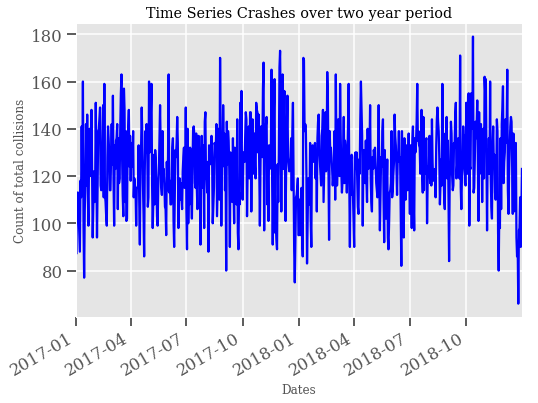

In [84]:
#time series

fig,ax = plt.subplots(figsize=(8,6))

time_series1 = la1['Date'].value_counts()

ax = time_series1.plot(color="blue")
#plt.show() = shows plot
ax.set_ylabel("Count of total collisions")
ax.set_xlabel("Dates")
ax.set_title('Time Series Crashes over two year period')

Text(0.5, 1.0, 'View of weekly patterns over a few months')

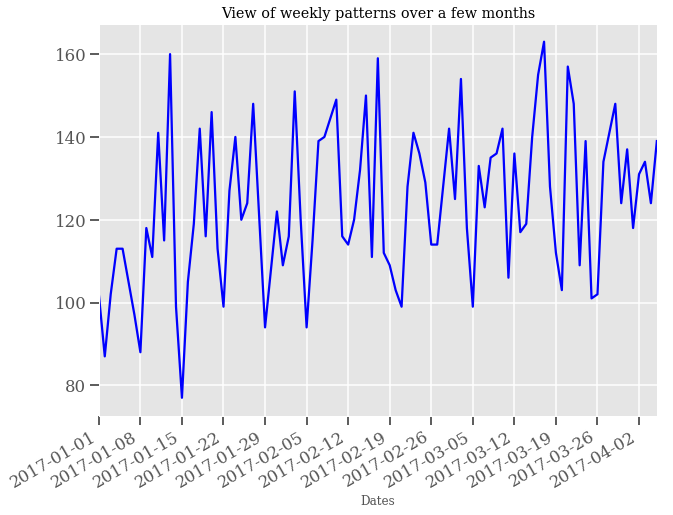

In [85]:
la2 = la1.copy()

la2.reset_index(inplace = True)

series_dates = la2['Date'].value_counts()

la2.set_index('Date', inplace = True)

time_series1 = la2['2017-01-01':'2017-04-05']

la2.reset_index(inplace= True)

time_series1.reset_index(inplace= True)


counts1 = time_series1['Date'].value_counts()


fig,ax = plt.subplots(figsize=(10,8))

ax = counts1.plot(color='blue')

tick_spacing = 7 # for each week

ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_xlabel("Dates")
ax.set_title("View of weekly patterns over a few months")



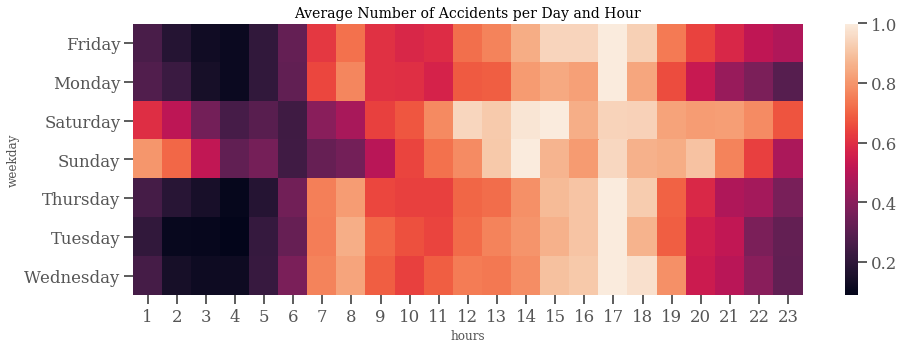

In [86]:
# accidents by weekday and hour

accidents_hour_pt = la.pivot_table(index='weekday', columns='hours', aggfunc='size')
accidents_hour_pt = accidents_hour_pt.apply(lambda x: x / accidents_hour_pt.max(axis=1))
plt.figure(figsize=(15,5))
plt.title('Average Number of Accidents per Day and Hour', fontsize=14)
sns.heatmap(accidents_hour_pt, cbar=True, annot=False, fmt=".0f");

# Unstructured Data from Twitter

This section includes an import of the tweets from Twitter with hashtags related to Los Angeles traffic such as #LAtraffic.  Please see the separate files with API and query code used to collect this data.

Since the volume of LA traffic related tweets was low, this data was not included in the analysis section above.  The majority of the tweets collected were with the #traffic hashtag which includes all tweets related to traffic and not just those from LA.

NOTE: This code has been commented out because it will not run unless you have a MongoDB file named twitterdb2 created.  You must also run the separate Twitter API file to collect tweets in the Mongo DB.

In [0]:
# from __future__ import print_function
# import tweepy
# import json
# import pymongo
# #import folium
# from pymongo import MongoClient
# client = MongoClient()

In [0]:
# client = MongoClient('localhost', 27017)
# db = client['twitterdb2']
# collection2 = db['twitter_search']
# docs = collection2.find()

In [0]:
# for doc in docs:
#     print(doc)

In [0]:
# collection2.find_one()

In addition to reading in tweets from MongoDB, the code below will also import tweet data from a CSV file.

In [0]:
# #Read in the csv with the LA traffic tweets
# import numpy as np
# import pandas as pd
# from os import path
# from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# import re
# #import matplotlib.pyplot as plt
# #% matplotlib inline
# tweets = pd.read_csv('/Users/johnfields/Library/Mobile Documents/com~apple~CloudDocs/Syracuse/IST652/MyPythonFiles/Homework2/output.csv')
# tweets = tweets[tweets['text'].str.contains('traffic')]
# tweets.info()